# Notes to self

  * What errors to put on the points? (Statistical by mock data, systematic somehow else?)
  * Two-sided errors

# Imports

In [1]:
%run 'psd_mc_functions.ipynb'

import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import os

Reading XAMS data from pickles...
Read data in 35.57 seconds


In [2]:
import pandas as pd
from tqdm import tqdm
import re
from time import sleep

In [3]:
data_dir = '/data/xenon/ehogenbi/pulsefit/processing_pickles'
#data_dir = '/home/erik/win/BCK/pulsefit_pickles_180114/'

# Functions

## Reading

In [4]:
def read_pickles(dirname, base_name, max_i = None):
    if max_i is None:
        fns = os.listdir(dirname)
        fns = [os.path.join(dirname, fn) for fn in fns if re.match(base_name + '_....pickle', fn)]#if base_name in fn]
        fns = np.sort(fns)
    else:
        fns = [os.path.join(dirname, base_name + '_%03d.pickle' % i) for i in range(max_i)]
    if len(fns) == 0:
        print('Found no filenames for base %s, skipping...' % base_name)
        return pd.DataFrame([])
    dicts = []
    for fn in fns:
        with open(fn, 'rb') as f:
            current_dict = pickle.load(f)
            dicts.append(current_dict)
            if 'chi2' not in current_dict[0].keys():
                print('Warning: found no chi2 in file %s' % fn)
    dicts =  np.concatenate(dicts)
    
    df = pd.DataFrame(list(dicts))
    if df.isnull().values.any():
        print('Warning: found some NaNs or Nones in the dataframe. Maybe check your computation results?')
    if 'chi2' not in df.keys():
        print('Warning: found no chi2 for %s. Are you reading unprocessed files?' % (base_name))
    print('Read %d datapoints from %d files.' % (len(df), len(fns)))
    if 'stored_stat' in df.keys():
        # Brainfart when I put this in
        df['stored_stat_value'] = df['stored_stat']
        df['stored_stat'] = True
    return df



In [5]:
def round_df(df, decimals = 3):
    '''Round all non-str values of the dataframe to string ones.'''
    for key in df.keys():
        if type(df[key].iloc[0]) == str:
            continue
        df[key] = np.round(df[key], decimals)
    return df

def remove_common(df1, df2, key_list = ['dset', 't3', 't1', 'fs', 'tts']):
    '''
    Remove all the elements in df1 that are already in df2 (comparing the keys in key_list)
    '''
    df1_sub = deepcopy(df1[key_list])
    df2_sub = deepcopy(df2[key_list])
    df1_sub = round_df(df1_sub)
    df2_sub = round_df(df2_sub)
    mask = np.invert(pd.concat([df1_sub,df2_sub]).duplicated(keep=False).values[:len(df1_sub)])
    print('Removing %d of %d items, already exist...' % (sum(np.invert(mask)), len(df1)))
    df1 = df1[mask]
    df1 = df1.reset_index(drop=True)
    return df1

In [6]:
def read_and_combine(dirname, list_of_base, remove_duplicates = True, key_list = ['dset', 't3', 't1', 'fs', 'tts']):
    '''
    Read dataframes with different base_name, merge dataframes and remove duplicates.
    '''
    df_list = []
    for base_name in list_of_base:
        df_list.append(read_pickles(dirname, base_name))
    df = pd.concat(df_list)
    df_keys = deepcopy(df[key_list])
    df_keys = round_df(df_keys)
    mask = np.invert(df_keys.duplicated().values)
    if sum(np.invert(mask)) > 0:
        print('Removing %d of %d items, already exist...' % (sum(np.invert(mask)), len(df)))
    # Reset the index after concatenating
    df = df.reset_index(drop=True)
    return df

In [7]:
def read_energy_bins(data_dir, base_name, e_bins):
    '''
    Read all datasets.
    Returns list of dataframes
    '''
    ddf = []
    for e_min, e_max in zip(e_bins[:-1], e_bins[1:]):
        df = read_pickles(data_dir, base_name + '_%02d_%02d' % (e_min, e_max))
        ddf.append(df)
    return ddf

In [8]:
def read_and_combine_energy_bins(data_dir, base_names, e_bins):
    ddf = []
    ddf = []
    for e_min, e_max in zip(e_bins[:-1], e_bins[1:]):
        df = read_and_combine(data_dir, [base_name + '_%02d_%02d' % (e_min, e_max) for base_name in base_names])
        ddf.append(df)
    return ddf

## Plotting

In [9]:
def parslice_2d(df, x, y, key = 'chi2', plot_min = True, vmax=None, noshow=False, **kwargs):
    '''
    Plot the minimum values of chi2 for two variables (i.e. a projection of the minimum onto the 2d slice)
    '''
    dfmin = df.sort_values(by=key).iloc[0]
    if vmax is None:
        vmax = dfmin['chi2'] * 1.5
    grouped = df.groupby(by = (x, y)).min()
    grouped[x] = grouped.index.get_level_values(x)
    grouped[y] = grouped.index.get_level_values(y)
    plt.scatter(grouped[x], grouped[y], c= grouped[key], vmax = vmax, **kwargs)
    plt.colorbar(label='chi2/ndf')
    if plot_min:
        plt.scatter(dfmin[x], dfmin[y], color='red', marker='+', s = 500)

    plt.xlabel(x)
    plt.ylabel(y)
    if not noshow:
        plt.show()

In [10]:
def plot_all_slices(df, vmax = None, key='chi2', **kwargs):
    '''
    Inspect the 2d slices to find the minimum.
    '''
    if vmax is None:
        vmax = np.min(df[key] * 1.5 )
    for x, y in zip(['t3', 't1', 't1'], ['fs', 'tts', 't3']):
        parslice_2d(df, x, y,key=key, vmax = vmax,  **kwargs)
    return

In [33]:
def plot_all_slices_rec(df, vmax = None, key='chi2', **kwargs):
    '''
    Inspect the 2d slices to find the minimum.
    '''
    if vmax is None:
        vmax = np.min(df[key] * 1.5 )
    for x, y in zip(['eta', 'eta', 'eta'], ['tr', 'fs_r', 'f_r']):
        parslice_2d(df, x, y,key=key, vmax = vmax,  **kwargs)
    return

In [12]:
def plot_slice_containing_point(df, x, y, row, **kwargs):
    df_sel = deepcopy(df)
    for key in row.keys():
        if (key == x) or (key == y) or (key=='chi2'):
            continue
        df_sel = df_sel[df_sel[key] == row[key]]
    plt.scatter(df_sel[x], df_sel[y], c= df_sel['chi2'], **kwargs)
    plt.xlabel(x)
    plt.ylabel(y)
    plt.colorbar(label='chi2/ndf')
    plt.show()

## Minimum stability

In [13]:
def get_some_minima(df, n_values=None, threshold=None, key='chi2'):
    '''
    Get the minimum n points of the dataframe up to chi2 value specified by threshold.
    If threshold is None, just take n values.
    If n_values is None, no restriction on the number of points.
    This function may be used to get the statistical error, although perhaps tricky how.
    Maximum deviation? std? 
    '''
    if n_values is None:
        selected_minima = df.sort_values(by = key)
    else:
        selected_minima = df.sort_values(by = key)[:n_values]
    if threshold is not None:
        selected_minima = selected_minima[selected_minima[key] <= threshold]
    print('Selected %d values with %s ranging from %.2f to %.2f...' % (len(selected_minima), 
                                                                       key,
                                                                         selected_minima[key].min(),
                                                                        selected_minima[key].max()))
    return deepcopy(selected_minima)

In [14]:
def scan_settings_and_get_min(x, df):
    '''
    x is a list of settings dicts, which may be produced by produce_settings_dict
    '''
    result = []
    for settings in tqdm(x):
        chi2 = recompute_chi2(df, **settings)
        minval = df.iloc[np.argmin(chi2)]
        minval = deepcopy(minval) # to shut up pandas
        minval = strip_junk(minval)
        minval['chi2'] = np.min(chi2)
        minval = merge_two_dicts(minval, settings)
        result.append(minval)
    return pd.DataFrame(result)

In [15]:
def check_minima(df, n_values, check_times):
    '''
    Take n minimum values, recompute them, take the mean and see if the minimum is still the minimum.
    '''
    electa = get_some_minima(df, n_values)
    electa['ranking_before'] = range(len(electa))
    chi2_new = []
    for index, settings in electa.iterrows():
        print('Working on setting %d' % index)
        settings = deepcopy(dict(settings))
        settings = strip_junk(settings)
        gofs = [gof(**settings) for _ in range(check_times)]
        chi2_new.append(np.average(gofs))
    electa['chi2_new_%d_times' % check_times] = chi2_new
    electa = electa.sort_values(by = 'chi2_new_%d_times' % check_times)
    electa['ranking_after'] = range(len(electa))
    electa = electa.sort_values(by='chi2')
    changed = electa['ranking_before'] != electa['ranking_after']
    if sum(changed) != 0:
        print('Warning: I detected a changing order!')
    return electa


In [16]:
def print_minima(mins):
    print('Giving the standard deviation for %d points...' % len(mins))
    for key in ['fs', 't3', 't1', 'tts']:
        print ("%s = %.3f +- %.3f" % (key, np.average(mins[key]), np.std(mins[key])))
    print('Giving the MAXIMUM deviation from BEST-FIT POINT (using chi2) for %d points...' % len(mins))
    bestfit = mins.sort_values(by='chi2').iloc[0]
    for key in ['fs', 't3', 't1', 'tts']:
        print ("%s = %.3f + %.3f - %.3f" % (key, bestfit[key],
                                            bestfit[key] - np.min(mins[key]),
                                            np.max(mins[key]) - bestfit[key]
                                           ))
    return

In [94]:
def recompute_chi2(df, **p):
    '''
    Recompute chi2 with new settings given in p.
    Parameters will be passed to `gof_manual`.
    '''
    chi2_new = []
    for i, row in df.iterrows():
        p2 = merge_two_dicts(dict(row), p)
        print(p2)
        chi2_new.append(gof_manual(verbose=False, **p2))
    return np.array(chi2_new)

In [18]:
def minvalue(df, key='chi2', to_input = False, keep_only_stored = False):
    '''
    Take the value where minimum occurs
    '''
    minrow = df.iloc[df[key].argmin()]
    minrow = dict(minrow)
    if to_input:
        # Prepare to input into recomputing
        return minrow
    else:
        if not keep_only_stored:
            minrow = {k : v for k, v in minrow.items() if (type(v) is not np.ndarray)}
        else:
            minrow = {k : v for k, v in minrow.items() if (type(v) is not np.ndarray or k is 'stored_stat_value')}
        return minrow

In [19]:
def build_fine_grid(df, n_values_min, keys, current_step_size, increase_factor = 2, 
                    keys_to_copy = ['dset', 'e_min', 'e_max', 'n_photons']):
    # Select the n_vaues_min points with lowest chi2
    mins = get_some_minima(df, n_values = n_values_min)
    all_points = []
    for _, minval in mins.iterrows():
        # Add points around each minimum point
        neighbours = produce_settings_dicts(keys, 
                               [minval[key] - current_step_size[i] for i, key in enumerate(keys)],
                               [minval[key] + current_step_size[i] for i, key in enumerate(keys)],
                               [1/increase_factor * current_step_size[i] for i in range(len(current_step_size))],
                                verbose=False
                              )
        all_points.append(neighbours)
    # This list will contain all the points
    all_points = np.concatenate(all_points)
    # Round and remove duplicates
    all_points = [{k : np.round(v, 5) for k, v in points.items()} for points in all_points]
    all_unique_points = [dict(t) for t in set([tuple(d.items()) for d in all_points])]
    print('Removed %d of %d settings that were nonunique, %d left...' % (len(all_points) - len(all_unique_points),
                                                                         len(all_points), len(all_unique_points)))
    # Now add all constant keys
    const_key_values = {key : df[key].iloc[0] for key in keys_to_copy}
    for i in range(len(all_unique_points)):
        for key in keys_to_copy:
            all_unique_points[i][key] = const_key_values[key]
    
    # Remove all points with too low t1 or tts 
    good_points = [d for d in all_unique_points if ((d['t1'] > 1e-3) and (d['tts'] > 1e-3))]
    print('Also removed %d points with zero t1 or tts, %d left!' % (len(all_unique_points) - len(good_points),
                                                                    len(good_points)))


    
    return good_points

In [20]:
def strip_junk(dic):
    dic['stored_stat_value'] = dic['stored_stat']
    dic = {k : v for k, v in dic.items() if (type(v) is not np.ndarray) or k == 'stored_stat_value' }
    return dic

## Mock data

In [21]:
from time import sleep
def generate_mock_and_refit(df, reps):
    '''
    Take the fit values from the dataframe df, simulate the waveforms using these values
    and then refit. This should quantify the statistical error on the procedure (can you call it that?)
    Repeat reps times.
    '''
    # Get one element for the print statements
    el = df.iloc[0]
    print('Dataset %s, %d to %d keV' % (el['dset'], el['e_min'], el['e_max']))
    minval = minvalue(df)
    del minval['n_photons'] # Commented because we want to match stats
    del minval['chi2']
    print('Here is the minimum:', minval)
    indices = []
    # Sleep for one second 
    sleep(1)
    # Generate the stat. error only once; this is time-consuming and the same for all mock data.
    mock_avg, mock_stored_stat = build_mock_data(verbose = False, return_stored=True, **minval)

    for i in tqdm(range(reps)):
        mock_avg = build_mock_data(verbose = False, return_stored=False, **minval)
        chi2s = []
        for index, row in df.iterrows():
            # Loop over all parameter points in the dataframe and get the chi2 value
            model, syst_err, spe_err = (row['model'], row['syst_err'], row['spe_err'])
            chi2 = gof_manual(mock_avg, model, syst_err, spe_err, stored_stat_value = mock_stored_stat, verbose=False)
            chi2s.append(chi2)
        # This list contains the index where the max values occur for all repetitions
        indices.append(np.argmin(chi2s))
    # This dict will hold summary values for all reps, mostly sigma
    err_dict = {}
    newfits = df.ix[indices]
    variables = ['t3', 't1', 'fs', 'tts']
    for var in variables:
        # Median and mean
        err_dict[var + '_median'] = np.percentile(newfits[var].values, 50)
        err_dict[var + '_mean'] = np.mean(newfits[var].values)
        # Percentiles: useful for skewed distributions
        err_dict['d' + var + '+'] = np.percentile(newfits[var].values, 50 + (68/2)) - err_dict[var + '_median']
        err_dict['d' + var + '-'] = err_dict[var + '_median'] - np.percentile(newfits[var].values, 50 - (68/2))
        # Sigma: useful for narrow distributions (since percentile will give you 0 sigma if almost all in one bin)
        err_dict['d' + var ] = np.std(newfits[var].values)
        
    return newfits, err_dict

In [22]:
def read_mock_data(reps, dsets = 'all', verbose=True):
    '''Read the data produced earlier'''
    if dsets == 'all':
        dsets = ['er', 'nr', 'er_l', 'nr_l', 'er_0']
    if verbose:
        print('Giving you the error for these datasets: ', dsets)
        
    # These objects are: a list (containing, er, nr, etc) of datasets (i.e. 2-5 keV, 5-10, etc) and for each dataset
    # the errors in those iterations or the list of iterations themselves if you want to be fancier.
    # Yeah. I know.
    all_errs_list = []
    all_newfits_list = []
    for dset in dsets:
        all_errs, all_newfits = pickle.load(open('mock_%s_%d_reps.pickle' % (dset, reps), 'rb'))
        all_errs_list.append(all_errs)
        all_newfits_list.append(all_newfits)
        
    return all_errs_list, all_newfits_list

## Placeholder

In [23]:
print('Done!')

Done!


In [22]:
# Run all above from this cell

# Reading results

### Statistical errors, fine grid production

In [250]:
mins = get_some_minima(df, 20)
print_minima(mins)

Selected 20 values with chi2 ranging from 1.54 to 2.16...
Giving the standard deviation for 20 points...
fs = 0.237 +- 0.010
t3 = 21.700 +- 0.458
t1 = 1.625 +- 0.444
tts = 1.512 +- 0.185


In [251]:
fine = build_fine_grid(df, 20, ['fs', 't3', 't1', 'tts'], [0.0125, 0.5, 0.5, 0.25])

Selected 20 values with chi2 ranging from 1.54 to 2.16...
Loaded 625 settings.
Loaded 625 settings.
Loaded 625 settings.
Loaded 625 settings.
Loaded 625 settings.
Loaded 625 settings.
Loaded 625 settings.
Loaded 625 settings.
Loaded 625 settings.
Loaded 625 settings.
Loaded 625 settings.
Loaded 625 settings.
Loaded 625 settings.
Loaded 625 settings.
Loaded 625 settings.
Loaded 625 settings.
Loaded 625 settings.
Loaded 625 settings.
Loaded 625 settings.
Loaded 625 settings.
Removed 6699 of 12500 settings that were nonunique, 5801 left...
Also removed 0 points with zero t1 or tts, 5801 left!


In [252]:
df_fine = pd.DataFrame(fine)

In [253]:
np.diff(np.unique(df['fs']))

array([ 0.0125,  0.0125,  0.0125,  0.0125])

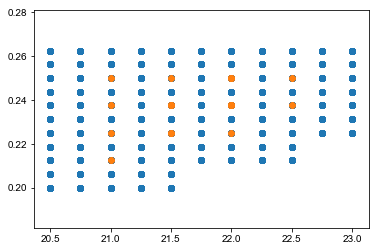

In [254]:
plt.scatter(df_fine['t3'], df_fine['fs'])
plt.scatter(mins['t3'], mins['fs'])
plt.show()

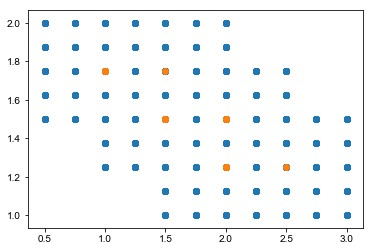

In [255]:
plt.scatter(df_fine['t1'], df_fine['tts'])
plt.scatter(mins['t1'], mins['tts'])
plt.show()

In [256]:
pickle.dump(fine, open('/data/xenon/ehogenbi/pulsefit/pickles/nr_finegrid.pickle', 'wb'))

### Systematic uncertainties

In [257]:
syst_settings = produce_settings_dicts(['t_min', 't_max', 'error_offset'], [-16, 100, 0], [-4, 150, 2e-4], [4, 10, 1e-4], 
                                   block_size = np.inf)

Loaded 72 settings.


In [258]:
mins = scan_settings_and_get_min(syst_settings, df)

100%|██████████| 72/72 [01:22<00:00,  1.09s/it]


In [259]:
print_minima(mins)

Giving the standard deviation for 72 points...
fs = 0.235 +- 0.010
t3 = 21.549 +- 0.207
t1 = 1.583 +- 0.400
tts = 1.458 +- 0.200


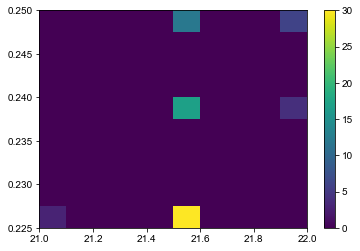

In [260]:
plt.hist2d(mins['t3'], mins['fs'])
plt.colorbar()
plt.show()

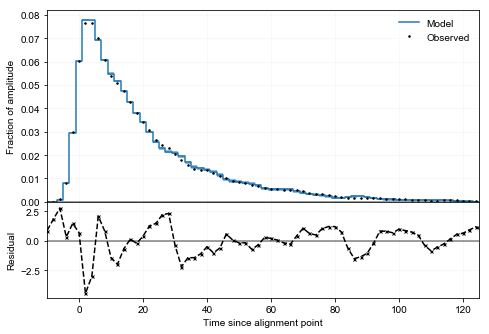

chi2 = 1.505357


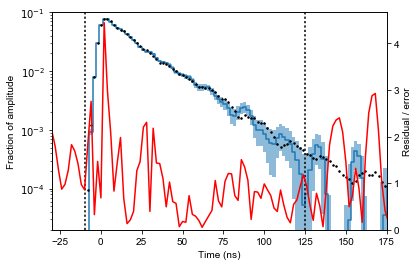

In [22]:
p = minvalue(df, key='chi2', to_input=True)
plot_model(verbose = False, **p)

In [25]:
minvalue(df)

{'chi2': 1.5359936092275124,
 'dset': 'nr',
 'fs': 0.23749999999999999,
 't1': 1.5,
 't3': 21.5,
 'tts': 1.5}

## ER energy scan

In [71]:
e_bins_er = [2, 5, 10, 20, 30, 50, 70]
ddf_er = read_and_combine_energy_bins(data_dir, ['er', 'er_f'], e_bins_er)

Read 6237 datapoints from 12 files.
Read 3953 datapoints from 13 files.
Read 6237 datapoints from 12 files.
Read 4592 datapoints from 15 files.
Read 5103 datapoints from 10 files.
Read 3961 datapoints from 13 files.
Read 5103 datapoints from 10 files.
Read 4063 datapoints from 13 files.
Read 5103 datapoints from 10 files.
Read 3877 datapoints from 12 files.
Read 5103 datapoints from 10 files.
Read 3952 datapoints from 13 files.


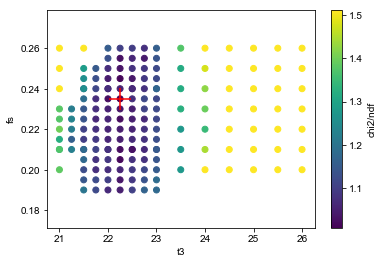

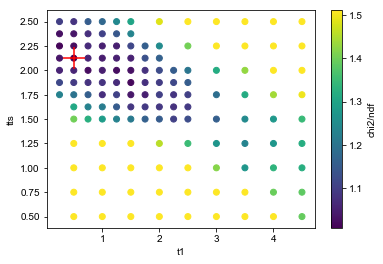

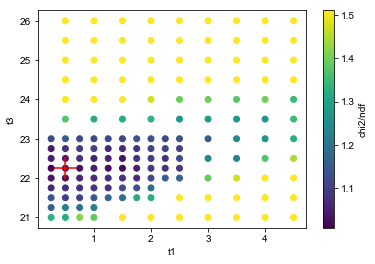

In [24]:
plot_all_slices(ddf_er[0])

In [26]:
minvalue(ddf_er[0])

{'chi2': 1.0076220581572282,
 'dset': 'er',
 'e_max': 5,
 'e_min': 2,
 'fs': 0.23499999999999999,
 'n_photons': 500000,
 'stored_stat': True,
 't1': 0.5,
 't3': 22.25,
 'tts': 2.125}

## NR energy scan

In [45]:
e_bins_nr = [2, 5, 10, 15]

In [46]:
ddf = read_and_combine_energy_bins(data_dir, ['nr', 'nr_f'], e_bins_nr)

Read 6534 datapoints from 13 files.
Found no filenames for base nr_f_02_05, skipping...
Read 6534 datapoints from 13 files.
Found no filenames for base nr_f_05_10, skipping...
Read 6534 datapoints from 13 files.
Read 4054 datapoints from 13 files.


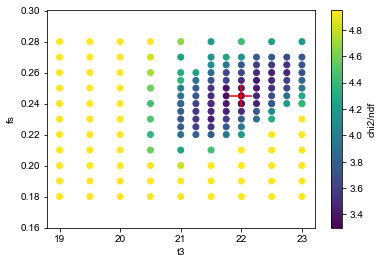

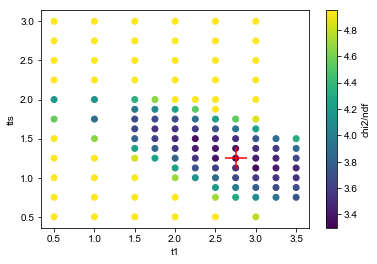

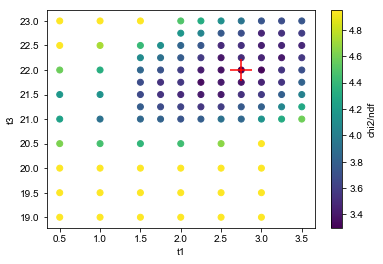

In [46]:
plot_all_slices(ddf_nr[2])

## ER low

In [22]:
ddf_er_l = read_and_combine_energy_bins(data_dir, ['er_l', 'er_l2', 'er_l_f'], [2, 5, 10, 20, 30, 50, 70])

Read 9801 datapoints from 9 files.
Found no filenames for base er_l2_02_05, skipping...
Read 4367 datapoints from 14 files.
Read 7290 datapoints from 7 files.
Read 2916 datapoints from 2 files.
Read 4575 datapoints from 15 files.
Read 5103 datapoints from 5 files.
Read 13068 datapoints from 13 files.
Read 4464 datapoints from 14 files.
Removing 3645 of 22635 items, already exist...
Read 6237 datapoints from 6 files.
Read 25200 datapoints from 25 files.
Read 4522 datapoints from 15 files.
Removing 3564 of 35959 items, already exist...
Read 5400 datapoints from 5 files.
Read 25740 datapoints from 25 files.
Read 4256 datapoints from 14 files.
Removing 1890 of 35396 items, already exist...
Read 5103 datapoints from 5 files.
Read 11880 datapoints from 11 files.
Read 3218 datapoints from 10 files.
Removing 675 of 20201 items, already exist...


In [37]:
df = ddf_er_l[5]

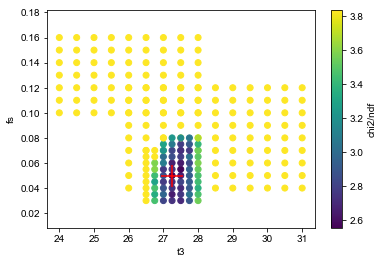

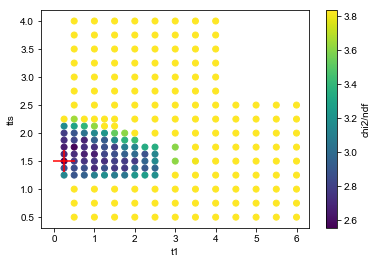

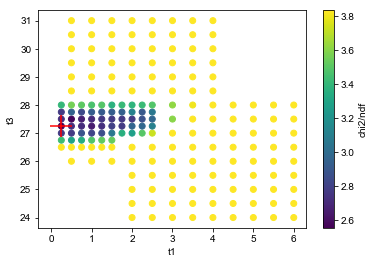

In [38]:
plot_all_slices(df)

In [39]:
minvalue(df)

{'chi2': 2.556434539617451,
 'dset': 'er_l',
 'e_max': 70,
 'e_min': 50,
 'fs': 0.050000000000000003,
 'n_photons': 2000000,
 'stored_stat': True,
 't1': 0.25,
 't3': 27.25,
 'tts': 1.5}

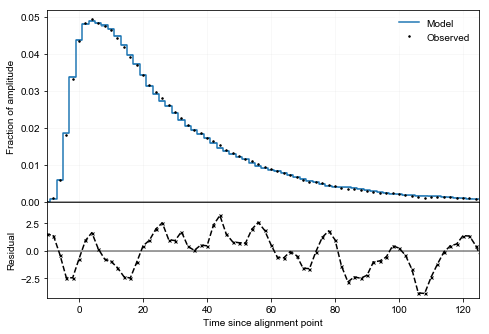

chi2 = 2.556435


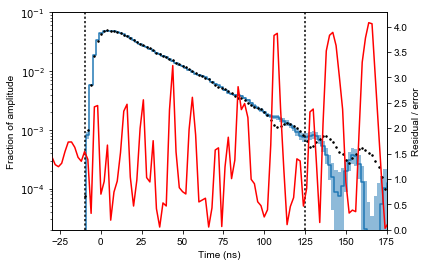

In [40]:
plot_model_manual(**minvalue(df, to_input=True))

## NR low

In [365]:
# for df in ddf_nr_l:
#     parslice_2d(df, 't3', 't1')

In [62]:
e_bins_nr = [2, 5, 10, 15]
ddf_nr_l = read_and_combine_energy_bins(data_dir, ['nr_l', 
                                                   # 'nr_l2',
                                                   'nr_l3', 
                                                   'nr_l_f'], e_bins_nr)
#ddf_nr_l = read_energy_bins(data_dir, 'nr_l', e_bins_nr)

Read 6534 datapoints from 13 files.
Read 15730 datapoints from 62 files.
Read 4720 datapoints from 15 files.
Removing 4185 of 26984 items, already exist...
Read 6534 datapoints from 13 files.
Read 15730 datapoints from 62 files.
Read 4445 datapoints from 14 files.
Removing 4179 of 26709 items, already exist...
Read 6534 datapoints from 13 files.
Read 15730 datapoints from 62 files.
Read 4306 datapoints from 14 files.
Removing 4167 of 26570 items, already exist...


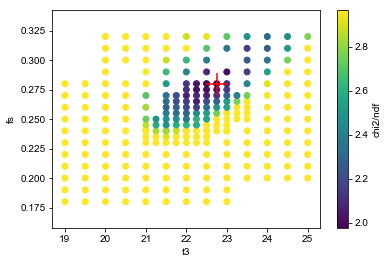

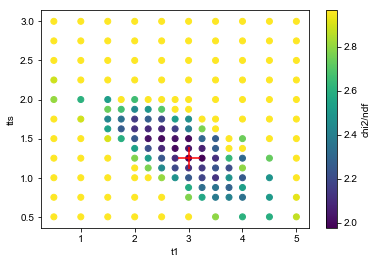

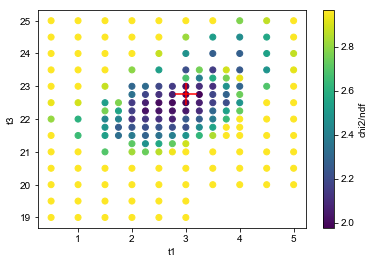

In [67]:
plot_all_slices(ddf_nr_l[1])

In [ ]:
# xs = [produce_settings_dicts(['t3', 'fs',  't1', 'tts'], lower_bound, upper_bound, step_size, 1000000, **p)
#         for (lower_bound, upper_bound, step_size, p) in zip(lower_bounds, upper_bounds, step_sizes, ps)]
# print('Produced a total of %d jobs for %d datasets.' % (np.sum([len(x) for x in xs]), len(xs)))
# ddf = read_energy_bins('/data/xenon/ehogenbi/pulsefit/processing_pickles/', 'nr_l', [2, 5, 10, 15])
# xs_new = []
# for x, df in zip(xs, ddf):
#     x = remove_common(pd.DataFrame(list(x)), df)
#     x = x.to_dict('records')
#     x = split_settings(x, 1000)
#     xs_new.append(xs)
# xs = xs_new

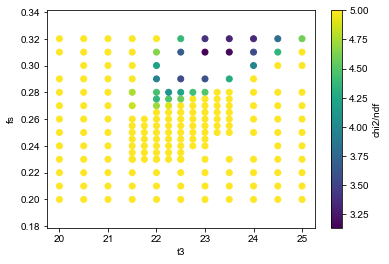

In [69]:
plot_slice_containing_point(ddf_nr_l[2], 't3', 'fs', minvalue(ddf_nr_l[2]), vmax = 5)

In [70]:
ddf = read_energy_bins('/data/xenon/ehogenbi/pulsefit/processing_pickles/', 'nr_l', [2, 5, 10, 15])

Read 6534 datapoints from 13 files.
Read 6534 datapoints from 13 files.
Read 6534 datapoints from 13 files.


## NR investigation

In [88]:
d = xams_data['nr']

In [96]:
xams_data.keys()

dict_keys(['nr', 'nr_l', 'bg_nr', 'er_l', 'er', 'er_0'])

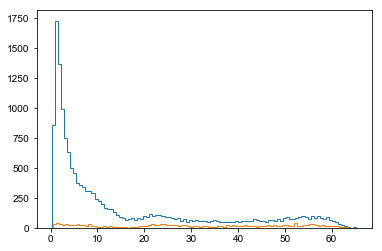

In [98]:
plt.hist(d['e_ces'], bins=100, histtype='step')
plt.hist(xams_data['bg_nr']['e_ces'], bins=100, histtype='step')
plt.show()

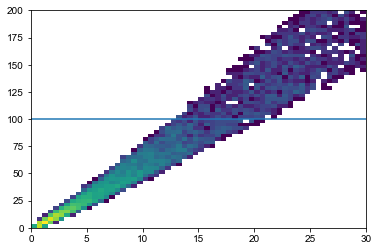

In [104]:
plt.hist2d(d['e_ces'], d['s1'], bins=60, norm=LogNorm(), range=((0, 30), (0, 200)))
plt.axhline(100)
plt.show()

Up to about 15 keVee is good.

In [112]:
p_nr = dict(n_photons = int(5e5), e_min = 10, e_max = 15, dset = 'nr', 
            # neglect_systematic = True, neglect_statistical = True,
            bootstrap_trials = 50,
            fs = 0.23, t3 = 22, t1 = 1.5, tts = 1.5
           )

{'t_min': -10.0, 'aft': 0.28, 'e_max': 15, 'stored_stat_value': None, 'stored_stat': True, 't3': 22, 't1': 1.5, 's1_model': 'two_exp', 'tts': 1.5, 'n_photons': 500000, 'error_offset': 0.0001, 's1_max': 600, 'eta': 0.0, 'neglect_statistical': False, 'fs_r': 0.2, 'e_min': 10, 'f_r': 0.0, 'tr': 15, 'bootstrap_trials': 50, 'error_pct': 0.0, 's1_min': 0, 'max_shift': 10, 'dset': 'nr', 'neglect_systematic': False, 't_max': 125.0, 'fs': 0.23}


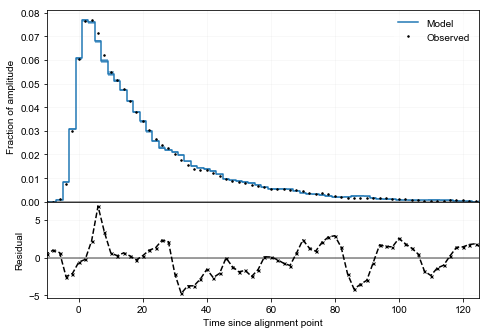

chi2 = 4.422413


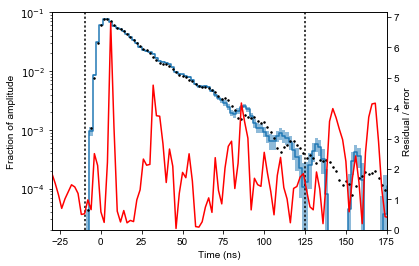

In [113]:
plot_model(**p_nr)

In [114]:
p_nr = dict(n_photons = int(5e5), e_min = 5, e_max = 10, dset = 'nr', 
            # neglect_systematic = True, neglect_statistical = True,
            bootstrap_trials = 50,
            fs = 0.23, t3 = 22, t1 = 1.5, tts = 1.5
           )

{'t_min': -10.0, 'aft': 0.28, 'e_max': 10, 'stored_stat_value': None, 'stored_stat': True, 't3': 22, 't1': 1.5, 's1_model': 'two_exp', 'tts': 1.5, 'n_photons': 500000, 'error_offset': 0.0001, 's1_max': 600, 'eta': 0.0, 'neglect_statistical': False, 'fs_r': 0.2, 'e_min': 5, 'f_r': 0.0, 'tr': 15, 'bootstrap_trials': 50, 'error_pct': 0.0, 's1_min': 0, 'max_shift': 10, 'dset': 'nr', 'neglect_systematic': False, 't_max': 125.0, 'fs': 0.23}


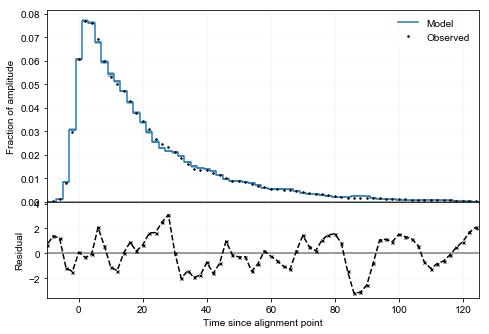

chi2 = 1.784474


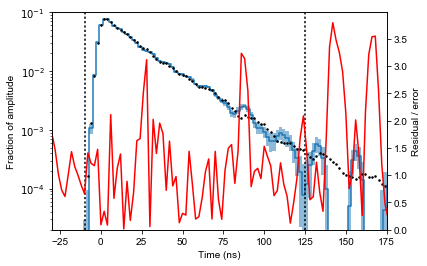

In [115]:
plot_model(**p_nr)

{'t_min': -10.0, 'aft': 0.28, 'e_max': 5, 'stored_stat_value': None, 'stored_stat': True, 't3': 22, 't1': 1.5, 's1_model': 'two_exp', 'tts': 1.5, 'n_photons': 500000, 'error_offset': 0.0001, 's1_max': 600, 'eta': 0.0, 'neglect_statistical': False, 'fs_r': 0.2, 'e_min': 2, 'f_r': 0.0, 'tr': 15, 'bootstrap_trials': 50, 'error_pct': 0.0, 's1_min': 0, 'max_shift': 10, 'dset': 'nr', 'neglect_systematic': False, 't_max': 125.0, 'fs': 0.23}


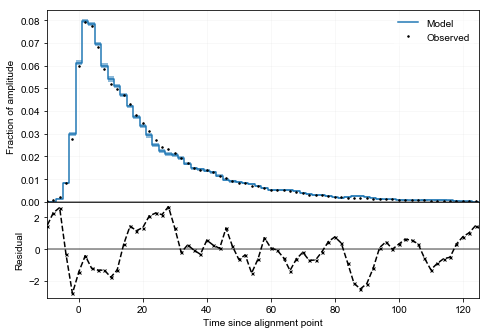

chi2 = 1.464754


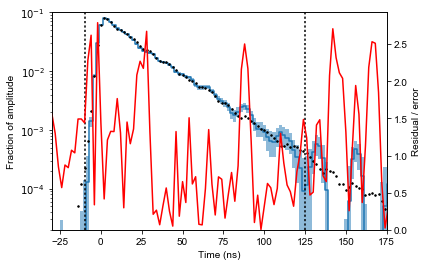

In [116]:
p_nr['e_min'] = 2
p_nr['e_max'] = 5
plot_model(**p_nr)

In [214]:
p = dict(
    # Dataset selection
    dset = 'er',
    e_min = 50,
    e_max = 70,
    
    # Speeding up computation
    neglect_systematic = True,
    neglect_statistical = False,
    bootstrap_trials = 10,
    
    # Fixed values
    t3 = 22.,
    t1 = 1.5,
    tts = 1.5,
    
    s1_model = 'recombination',
    fs = 0.1,
    tr = 200,
    f_r = 0.1,
    fs_r = 0.5,
)

In [215]:
# stored_stat_value = real_s1_wv_sigma(**p)

In [216]:
 p['stored_stat_value'] = stored_stat_value

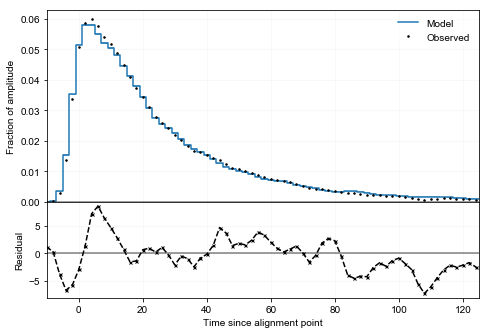

chi2 = 10.334201


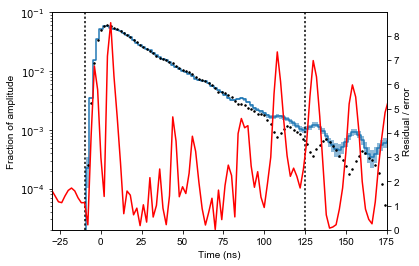

In [217]:
plot_model(verbose=False, **p)

## ER zero

In [72]:
df_0 = read_pickles('/data/xenon/ehogenbi/pulsefit/processing_pickles/', 'er_0_10_20')

Read 23760 datapoints from 118 files.


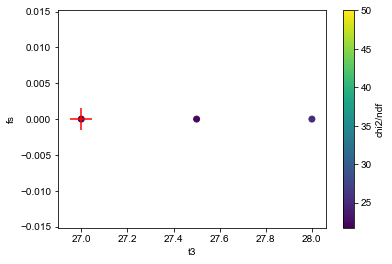

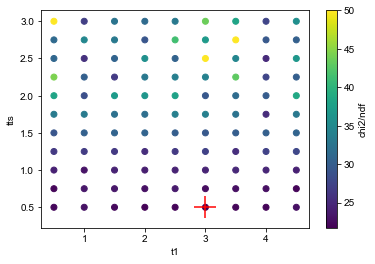

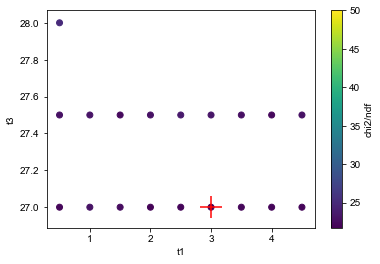

In [75]:
plot_all_slices(df_0, vmax=50)

# Process all four-fit data

### Functions

In [24]:
def min_per_e(ddf, dset, chi2_max = None, chi2_max_factor = None, mode='std'):
    '''
    Get the parameters where chi2 is minimal up to a certain chi2 value.
    This gives the statistical error
    '''
    d = xams_data[dset]
    x = []

    for i, df in enumerate(ddf):
        fit = {}
        e_min = df.iloc[0]['e_min']
        e_max = df.iloc[0]['e_max']
        fit['e'] = np.average(d[(d['e_ces'] >= e_min) & (d['e_ces'] < e_max)]['e_ces'])
        fit['de'] = np.std(d[(d['e_ces'] >= e_min) & (d['e_ces'] < e_max)]['e_ces'])
        if chi2_max is not None:
            mins = get_some_minima(df, threshold=df['chi2'].min() * chi2_max)
        elif chi2_max_factor is not None:
            mins = get_some_minima(df, threshold=df['chi2'].min() * chi2_max_factor) 
        else:
            raise ValueError('Configuration not understood.')
        for key in ['t3', 't1', 'fs', 'tts']:
            fit[key] = np.mean(mins[key])
            if mode == 'std':
                fit['d' + key] = np.std(mins[key])
            elif mode == 'extreme':
                fit['d' + key] = 0.5 * (np.max(mins[key]) - np.min(mins[key]))
        x.append(fit)
    x = pd.DataFrame(x)
    return x

In [87]:
def min_per_e_syst(ddf, dset, settings, appendix = ''):
    '''
    Get the values of paramters where chi2 is minimal if parameters are varied. 
    '''
    all_mins = []
    for i, df in enumerate(ddf):
        mins = scan_settings_and_get_min(settings, df)
        print(mins)
        all_mins.append(mins)
    with open('pickle_dir/mins_per_e_%s' + appendix + '.pickle' % dset, 'wb') as f:
        pickle.dump(all_mins, f)
    return all_mins

In [26]:
def process_mins(ddf, dset, mins_per_e = None):
    '''
    Requires a list of dataframes containing the minimum values.
    '''
    if mins_per_e is None:
        with open('pickle_dir/mins_per_e_%s.pickle' % dset, 'rb') as f:
            mins_per_e = pickle.load(f)
            print('Read %d settings in %d bins from file.' % (len(mins_per_e[0]), len(mins_per_e)))
    d = xams_data[dset]
    x = []
    for mins, df in zip(mins_per_e, ddf):
        fit = {}
        e_min = df.iloc[0]['e_min']
        e_max = df.iloc[0]['e_max']
        fit['e'] = np.average(d[(d['e_ces'] >= e_min) & (d['e_ces'] < e_max)]['e_ces'])
        fit['de'] = np.std(d[(d['e_ces'] >= e_min) & (d['e_ces'] < e_max)]['e_ces'])
        for key in ['t3', 't1', 'fs', 'tts', 'chi2']:
            fit[key] = np.mean(mins[key])
            fit['d' + key] = np.std(mins[key])
        x.append(fit)
    x = pd.DataFrame(x)
    return x

In [27]:
def process_and_combine_syst_and_stat(ddf, dset, chi2_max_factor, mode, verbose = False):
    '''
    Depricated as of 
    '''
    x_stat = min_per_e(ddf, dset, chi2_max_factor = chi2_max_factor, mode=mode)
    x_syst = process_mins(ddf, dset) # assuming all from file
    # COMBINE ALL
    x = []
    for i in range(len(x_stat)):
        fit = {}
        for key in ['e', 'de', 'chi2', 'dchi2']:
            fit[key] = x_syst[key].values[i]
        minval = minvalue(ddf[i])
        for key in ['t3', 't1', 'fs', 'tts']:
            # For the minimum, just take the value that is the minimum
            fit[key] = minval[key]
            fit['d' + key + '_syst'] = x_syst['d' + key].values[i]
            fit['d' + key + '_stat'] = x_stat['d' + key].values[i]
            fit['d' + key] = np.sqrt(fit['d' + key + '_syst']**2 + fit['d' + key + '_syst']**2)
        x.append(fit)
    return pd.DataFrame(x)

### Read

In [28]:
# Energy bins
e_bins_er = [2, 5, 10, 20, 30, 50, 70]
e_bins_nr = [2, 5, 10, 15]
e_bins_er_0 = [10, 20, 30, 40, 50]

In [29]:
# Reading the dataframes
ddf_er = read_and_combine_energy_bins(data_dir, ['er', 'er_f'], e_bins_er)
ddf_er_l = read_and_combine_energy_bins(data_dir, ['er_l', 'er_l2', 'er_l_f', 'er_l_f2'], e_bins_er)
ddf_nr = read_and_combine_energy_bins(data_dir, ['nr', 'nr_f'], e_bins_nr)
ddf_nr_l = read_and_combine_energy_bins(data_dir, ['nr_l',  # 'nr_l2'
                                                   'nr_l3', 'nr_l_f', 'nr_l_f2', 'nr_l_f3'], e_bins_nr)
ddf_er_0 = read_and_combine_energy_bins(data_dir, ['er_0', 'er_0_f2'], e_bins_er_0)
print('Done')

Read 6237 datapoints from 12 files.
Read 3953 datapoints from 13 files.
Read 6237 datapoints from 12 files.
Read 4592 datapoints from 15 files.
Read 5103 datapoints from 10 files.
Read 3961 datapoints from 13 files.
Read 5103 datapoints from 10 files.
Read 4063 datapoints from 13 files.
Read 5103 datapoints from 10 files.
Read 3877 datapoints from 12 files.
Read 5103 datapoints from 10 files.
Read 3952 datapoints from 13 files.
Read 9801 datapoints from 9 files.
Found no filenames for base er_l2_02_05, skipping...
Read 4367 datapoints from 14 files.
Read 749 datapoints from 2 files.
Read 7290 datapoints from 7 files.
Read 2916 datapoints from 2 files.
Read 4575 datapoints from 15 files.
Read 836 datapoints from 2 files.
Read 5103 datapoints from 5 files.
Read 13068 datapoints from 13 files.
Read 4464 datapoints from 14 files.
Read 520 datapoints from 1 files.
Removing 3645 of 23155 items, already exist...
Read 6237 datapoints from 6 files.
Read 25200 datapoints from 25 files.
Read 4522

In [86]:
dsets = ['er', 'nr', 'er_l', 'nr_l', 'er_0']
dddf = [ddf_er, ddf_nr, ddf_er_l, ddf_nr_l, ddf_er_0]

### Recombination model

In [35]:
ddf_er_0_rec = read_and_combine_energy_bins(data_dir, ['er_0_recomb', 'er_0_recomb2', 'er_0_f_rec'], e_bins_er_0)

Read 33033 datapoints from 22 files.
Read 15246 datapoints from 10 files.
Read 6380 datapoints from 21 files.
Removing 54658 of 54659 items, already exist...
Read 35574 datapoints from 23 files.
Found no filenames for base er_0_recomb2_20_30, skipping...
Read 6581 datapoints from 21 files.
Removing 42154 of 42155 items, already exist...
Read 35574 datapoints from 23 files.
Found no filenames for base er_0_recomb2_30_40, skipping...
Read 6533 datapoints from 21 files.
Removing 42106 of 42107 items, already exist...
Read 33033 datapoints from 22 files.
Read 15246 datapoints from 10 files.
Read 6597 datapoints from 21 files.
Removing 54875 of 54876 items, already exist...


### Check all grids

In [55]:
ddf = ddf_er_0

slice 0


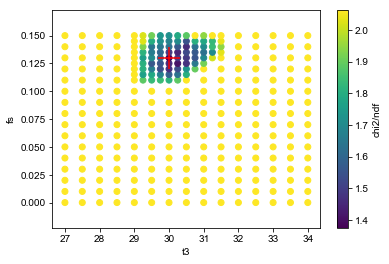

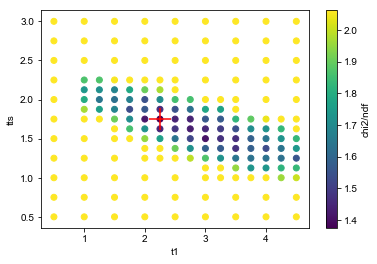

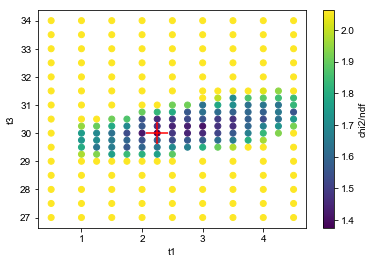

+++++++++++++++++++++++++++++++++++++++++++++
slice 1


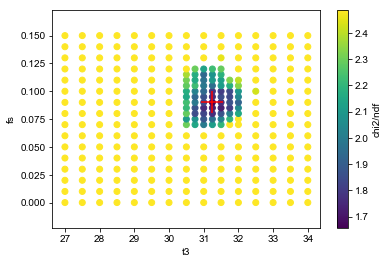

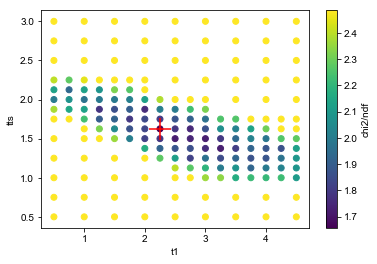

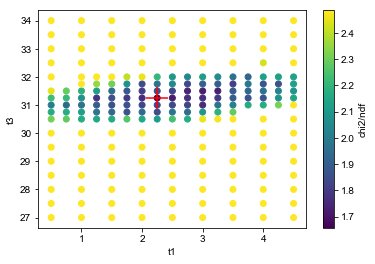

+++++++++++++++++++++++++++++++++++++++++++++
slice 2


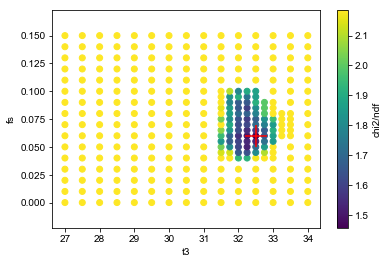

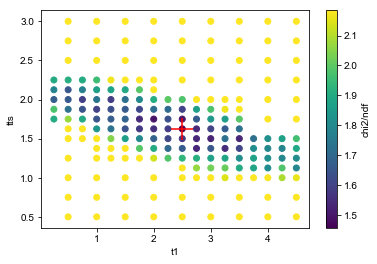

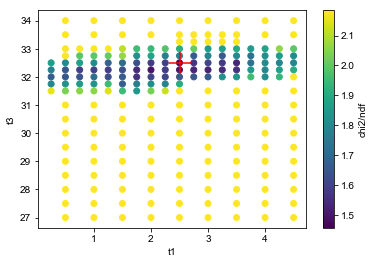

+++++++++++++++++++++++++++++++++++++++++++++
slice 3


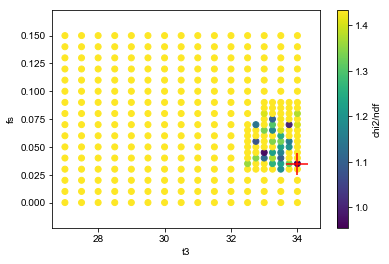

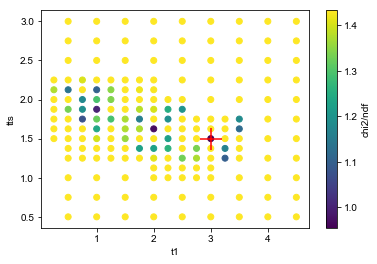

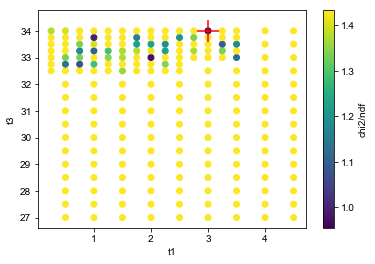

+++++++++++++++++++++++++++++++++++++++++++++


In [56]:
for i, df in enumerate(ddf):
    print('slice %d' % i)
    plot_all_slices(df)
    print('+++++++++++++++++++++++++++++++++++++++++++++')

In [76]:
df = ddf[3]

In [77]:
np.unique(df[(df['chi2'] < 35)]['n_photons'].values)

array([  20000, 1000000])

In [79]:
df[(df['chi2'] < 35)]['n_photons'].values

array([1000000, 1000000, 1000000, ...,   20000,   20000,   20000])

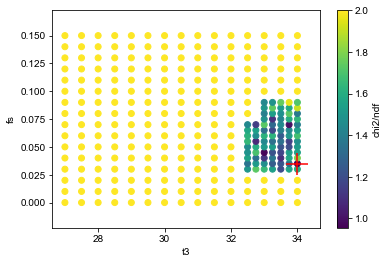

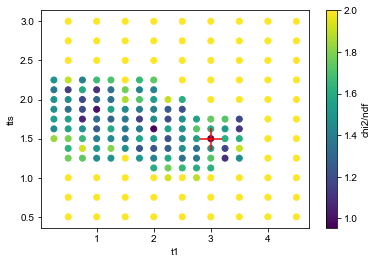

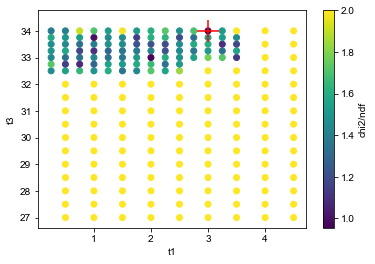

In [57]:
plot_all_slices(ddf[3], vmax=2)

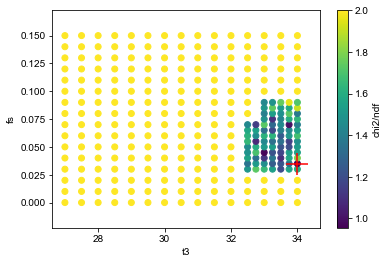

In [60]:
parslice_2d(ddf[3], 't3', 'fs', vmax=2)

In [ ]:
#  for f in  *_f[0-9]*; do mv "$f" "${f//_f/_f_}"; done

### Check recombination

slice 0


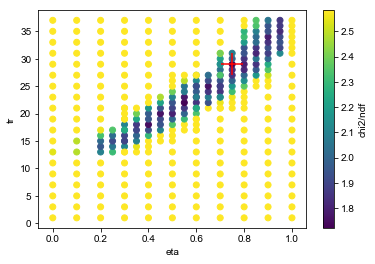

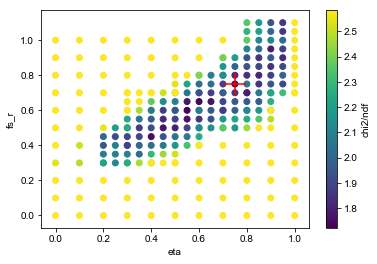

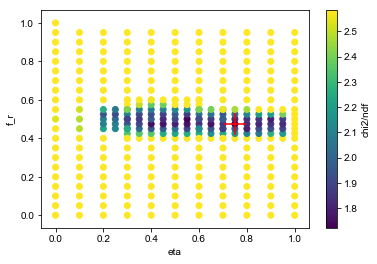

+++++++++++++++++++++++++++++++++++++++++++++
slice 1


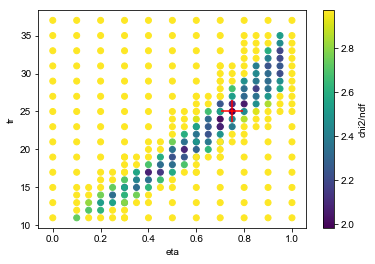

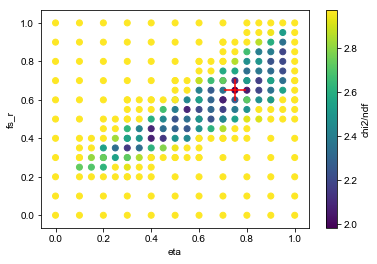

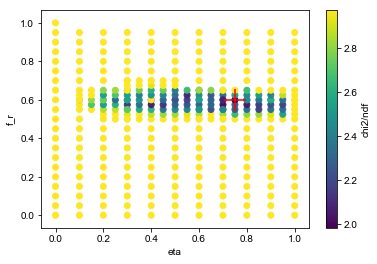

+++++++++++++++++++++++++++++++++++++++++++++
slice 2


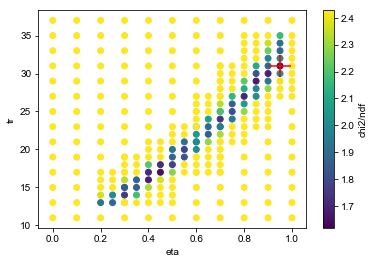

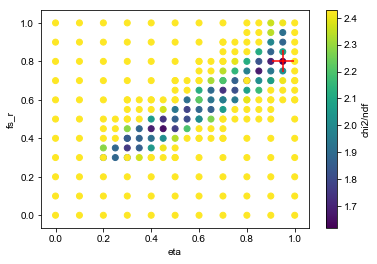

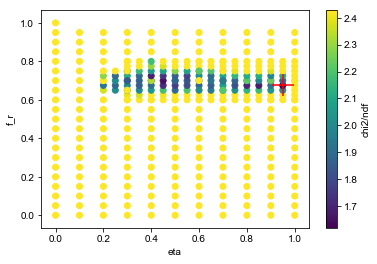

+++++++++++++++++++++++++++++++++++++++++++++
slice 3


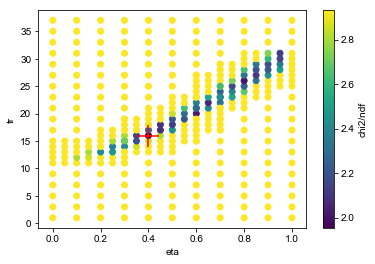

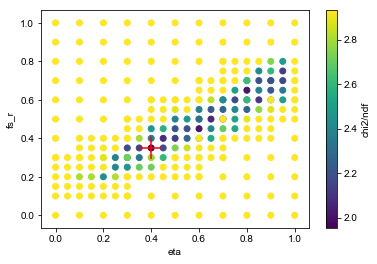

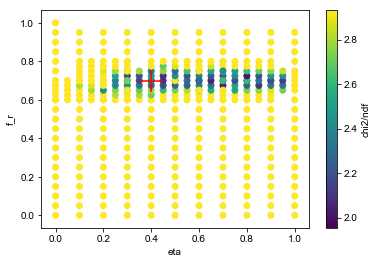

+++++++++++++++++++++++++++++++++++++++++++++


In [84]:
for i, df in enumerate(ddf_er_0_rec):
    print('slice %d' % i)
    plot_all_slices_rec(df)
    print('+++++++++++++++++++++++++++++++++++++++++++++')

In [82]:
for df in ddf_er_0_rec:
    print(np.unique(df[(df['chi2'] < 35)]['n_photons']))

[1000000]
[1000000]
[1000000]
[1000000]


## Systematic errors

### Production

In [89]:
settings = produce_settings_dicts(['t_min', 't_max', 'error_offset'], 
                                  [-12, 110, 0], [-6, 140, 2e-4], [2, 5, 1e-4], block_size=100000)

Loaded 84 settings.


In [93]:
for ddf, dset in zip(dddf, dsets):
    if dset in []:
        print('Skipping dset %s ...' % dset)
        continue
    print('Now processing dset %s' % dset)
    systscan = min_per_e_syst(ddf, dset, settings)


  0%|          | 0/84 [00:00<?, ?it/s]

Now processing dset er



  7%|▋         | 6/84 [00:21<04:43,  3.63s/it]

KeyboardInterrupt: 

In [92]:
ddf_er_0_rec[0]

chi2  dset  e_max  e_min   eta    f_r    fs  fs_r  \
0      145.830641  er_0     20     10  0.00  0.000  0.23  0.00   
1      162.416814  er_0     20     10  0.00  0.000  0.23  0.00   
2      122.159582  er_0     20     10  0.00  0.000  0.23  0.00   
3      111.768440  er_0     20     10  0.00  0.000  0.23  0.00   
4      141.056402  er_0     20     10  0.00  0.000  0.23  0.00   
5      129.482005  er_0     20     10  0.00  0.000  0.23  0.00   
6       98.265305  er_0     20     10  0.00  0.000  0.23  0.00   
7      135.483483  er_0     20     10  0.00  0.000  0.23  0.00   
8      143.076105  er_0     20     10  0.00  0.000  0.23  0.00   
9      121.380276  er_0     20     10  0.00  0.000  0.23  0.00   
10     109.292968  er_0     20     10  0.00  0.000  0.23  0.00   
11     121.670747  er_0     20     10  0.00  0.000  0.23  0.00   
12     133.437614  er_0     20     10  0.00  0.000  0.23  0.00   
13     123.796906  er_0     20     10  0.00  0.000  0.23  0.10   
14     137.652483  er_0     20     10  0.00  0.000  0.23  0.10   
15     112.770507  er_0     20     10  0.00  0.000  0.23  0.10   
16     123.691462  er_0     20     10  0.00  0.000  0.23  0.10   
17     122.075909  er_0     20     10  0.00  0.000  0.23  0.10   
18     125.659980  er_0     20     10  0.00  0.000  0.23  0.10   
19     111.026574  er_0     20     10  0.00  0.000  0.23  0.10   
20     160.411733  er_0     20     10  0.00  0.000  0.23  0.10   
21     121.573293  er_0     20     10  0.00  0.000  0.23  0.10   
22     117.021690  er_0     20     10  0.00  0.000  0.23  0.10   
23     137.713527  er_0     20     10  0.00  0.000  0.23  0.10   
24     101.766150  er_0     20     10  0.00  0.000  0.23  0.10   
25     134.677478  er_0     20     10  0.00  0.000  0.23  0.10   
26     114.901688  er_0     20     10  0.00  0.000  0.23  0.20   
27     123.243314  er_0     20     10  0.00  0.000  0.23  0.20   
28     115.331141  er_0     20     10  0.00  0.000  0.23  0.20   
29     115.757059  er_0     20     10  0.00  0.000  0.23  0.20   
...           ...   ...    ...    ...   ...    ...   ...   ...   
54629    6.415015  er_0     20     10  0.80  0.550  0.23  1.00   
54630    7.558593  er_0     20     10  0.45  0.400  0.23  0.40   
54631    6.281046  er_0     20     10  0.20  0.525  0.23  0.40   
54632   17.693743  er_0     20     10  0.40  0.525  0.23  0.30   
54633    5.658645  er_0     20     10  0.45  0.525  0.23  0.40   
54634    3.587425  er_0     20     10  0.50  0.525  0.23  0.70   
54635   11.130183  er_0     20     10  0.45  0.525  0.23  0.65   
54636    9.953875  er_0     20     10  0.75  0.525  0.23  0.70   
54637    2.940913  er_0     20     10  0.80  0.450  0.23  0.90   
54638    4.085138  er_0     20     10  0.50  0.500  0.23  0.55   
54639   13.741148  er_0     20     10  0.75  0.500  0.23  0.80   
54640    2.489767  er_0     20     10  0.60  0.425  0.23  0.45   
54641    4.253790  er_0     20     10  0.55  0.450  0.23  0.70   
54642    4.088510  er_0     20     10  0.75  0.500  0.23  0.55   
54643    2.154150  er_0     20     10  0.90  0.500  0.23  0.85   
54644    1.855096  er_0     20     10  0.85  0.500  0.23  0.90   
54645    2.823426  er_0     20     10  0.60  0.425  0.23  0.50   
54646    2.978358  er_0     20     10  0.85  0.425  0.23  0.50   
54647   12.454371  er_0     20     10  0.75  0.450  0.23  0.80   
54648    3.422964  er_0     20     10  0.50  0.450  0.23  0.55   
54649  212.203095  er_0     20     10  1.00  0.550  0.23  1.10   
54650    4.933947  er_0     20     10  0.85  0.525  0.23  0.80   
54651    7.645958  er_0     20     10  0.85  0.400  0.23  0.80   
54652    8.453932  er_0     20     10  0.60  0.525  0.23  0.40   
54653    4.991574  er_0     20     10  0.35  0.400  0.23  0.40   
54654    8.060497  er_0     20     10  0.35  0.525  0.23  0.40   
54655    6.510999  er_0     20     10  0.35  0.525  0.23  0.65   
54656   12.034160  er_0     20     10  0.60  0.525  0.23  0.65   
54657    6.572286  er_0     20     10  0.95  0.450  0

In [90]:
systscan_rec = min_per_e_syst(ddf_er_0_rec, 'er_0', settings, appendix = '_rec')

  0%|          | 0/84 [00:00<?, ?it/s]

TypeError: argument of type 'numpy.float64' is not iterable

### Read result back

## Mock data error and validation

### Build mock data error

Here, build the error for all the data.

In [31]:

reps = 100
for ddf, name in zip([ddf_er, ddf_nr, ddf_er_l, ddf_nr_l], ['er', 'nr', 'er_l', 'nr_l']):
    if name in ['er', 'nr', 'er_l', 'nr_l']:
        print('Skipping dataset %s' % name)
        continue
    all_newfits = []
    all_errs = []
    for df in ddf:
        newfits, err_dict = generate_mock_and_refit(df, reps)
        all_newfits.append(newfits)
        all_errs.append(err_dict)
    pickle.dump((all_errs, all_newfits), open('mock_%s_%d_reps.pickle' % (name, reps), 'wb'))

Skipping dataset er
Dataset nr, 2 to 5 keV
Here is the minimum: {'stored_stat': True, 'tts': 1.75, 't3': 21.5, 'e_min': 2, 'fs': 0.23000000000000001, 'e_max': 5, 'dset': 'nr', 't1': 0.5}


100%|██████████| 100/100 [04:19<00:00,  2.54s/it]


Dataset nr, 5 to 10 keV
Here is the minimum: {'stored_stat': True, 'tts': 1.5, 't3': 21.5, 'e_min': 5, 'fs': 0.22, 'e_max': 10, 'dset': 'nr', 't1': 1.5}


100%|██████████| 100/100 [04:35<00:00,  2.79s/it]


Dataset nr, 10 to 15 keV
Here is the minimum: {'stored_stat': True, 'tts': 1.25, 't3': 22.0, 'e_min': 10, 'fs': 0.245, 'e_max': 15, 'dset': 'nr', 't1': 2.75}


100%|██████████| 100/100 [04:02<00:00,  2.35s/it]


Dataset er_l, 2 to 5 keV
Here is the minimum: {'stored_stat': True, 'tts': 2.125, 't3': 23.25, 'e_min': 2, 'fs': 0.25, 'e_max': 5, 'dset': 'er_l', 't1': 0.25}


100%|██████████| 100/100 [04:47<00:00,  2.87s/it]


Dataset er_l, 5 to 10 keV
Here is the minimum: {'stored_stat': True, 'tts': 1.75, 't3': 24.0, 'e_min': 5, 'fs': 0.16, 'e_max': 10, 'dset': 'er_l', 't1': 1.75}


100%|██████████| 100/100 [04:59<00:00,  2.99s/it]


Dataset er_l, 10 to 20 keV
Here is the minimum: {'stored_stat': True, 'tts': 1.5, 't3': 24.5, 'e_min': 10, 'fs': 0.12000000000000001, 'e_max': 20, 'dset': 'er_l', 't1': 2.0}


100%|██████████| 100/100 [07:34<00:00,  4.45s/it]


Dataset er_l, 20 to 30 keV
Here is the minimum: {'stored_stat': True, 'tts': 1.5, 't3': 25.5, 'e_min': 20, 'fs': 0.085000000000000006, 'e_max': 30, 'dset': 'er_l', 't1': 3.5}


100%|██████████| 100/100 [11:45<00:00,  7.11s/it]


Dataset er_l, 30 to 50 keV
Here is the minimum: {'stored_stat': True, 'tts': 1.625, 't3': 26.25, 'e_min': 30, 'fs': 0.055, 'e_max': 50, 'dset': 'er_l', 't1': 2.0}


100%|██████████| 100/100 [12:06<00:00,  7.21s/it]


Dataset er_l, 50 to 70 keV
Here is the minimum: {'stored_stat': True, 'tts': 1.5, 't3': 27.25, 'e_min': 50, 'fs': 0.050000000000000003, 'e_max': 70, 'dset': 'er_l', 't1': 0.25}


100%|██████████| 100/100 [07:58<00:00,  4.87s/it]


Dataset nr_l, 2 to 5 keV
Here is the minimum: {'stored_stat': True, 'tts': 1.5, 't3': 22.25, 'e_min': 2, 'fs': 0.255, 'e_max': 5, 'dset': 'nr_l', 't1': 2.5}


100%|██████████| 100/100 [09:00<00:00,  5.40s/it]


Dataset nr_l, 5 to 10 keV
Here is the minimum: {'stored_stat': True, 'tts': 1.25, 't3': 22.75, 'e_min': 5, 'fs': 0.28000000000000003, 'e_max': 10, 'dset': 'nr_l', 't1': 3.0}


100%|██████████| 100/100 [08:53<00:00,  5.29s/it]


Dataset nr_l, 10 to 15 keV
Here is the minimum: {'stored_stat': True, 'tts': 1.25, 't3': 23.0, 'e_min': 10, 'fs': 0.31, 'e_max': 15, 'dset': 'nr_l', 't1': 3.5}


100%|██████████| 100/100 [08:36<00:00,  5.16s/it]


### Read result back

In [57]:
all_errs_list, all_newfits_list = read_mock_data(reps=100)

Giving you the error for these datasets:  ['er', 'nr', 'er_l', 'nr_l']


### Inspection

In [83]:
dseti = 3
var = 't3'

print('Choosing dataset %s' % dsets[dseti])


Choosing dataset nr_l


In [84]:
x_plot = range(len(dddf[dseti]))
y_feed = [minvalue(df)[var] for df in dddf[dseti]] # The value used for the mock datasets
y_med  = [err[var + '_median'] for err in all_errs_list[dseti]]
y_mean = [err[var + '_mean'] for err in all_errs_list[dseti]]
dyplus = [err['d' + var + '+'] for err in all_errs_list[dseti]]
dymin  = [err['d' + var + '-'] for err in all_errs_list[dseti]]
dysig  = [err['d' + var] for err in all_errs_list[dseti]]

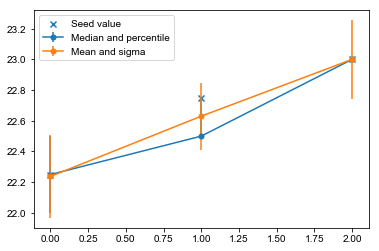

In [85]:
plt.scatter(x_plot, y_feed, label='Seed value', marker='x')
plt.errorbar(x_plot, y_med, (dymin, dyplus), marker='.', markersize = 10, label='Median and percentile')
plt.errorbar(x_plot, y_mean, dysig, marker='.', markersize = 10, label='Mean and sigma')
plt.legend()

In [52]:
all_errs[-1]

{'dfs': 0.0059866518188382949,
 'dfs+': 0.0,
 'dfs-': 0.0015999999999999903,
 'dt1': 0.099498743710661988,
 'dt1+': 0.0,
 'dt1-': 0.0,
 'dt3': 0.25495097567963926,
 'dt3+': 0.0,
 'dt3-': 0.0,
 'dtts': 0.035355339059327376,
 'dtts+': 0.0,
 'dtts-': 0.0,
 'fs_mean': 0.30959999999999999,
 'fs_median': 0.31,
 't1_mean': 3.4900000000000002,
 't1_median': 3.5,
 't3_mean': 23.0,
 't3_median': 23.0,
 'tts_mean': 1.25,
 'tts_median': 1.25}

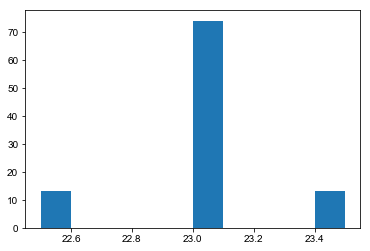

In [86]:
plt.hist(all_newfits[-1]['t3'])
plt.show()

## x production

Here we produce dataframes containing the errors, basically, all the point that will be in the large plot with all the panels.

### Statistical

In [76]:
def process_mins_mock(dddf, all_errs_list, dsets):
    '''Loop over datasets, then energy bins, and return the errors'''
    x_list = []
    for ddf, dset, all_errs in zip(dddf, dsets, all_errs_list):
        d = xams_data[dset]
        x = []
        for errs, df in zip(all_errs, ddf):
            fit = {}
            e_min = df.iloc[0]['e_min']
            e_max = df.iloc[0]['e_max']
            fit['e'] = np.average(d[(d['e_ces'] >= e_min) & (d['e_ces'] < e_max)]['e_ces'])
            fit['de'] = np.std(d[(d['e_ces'] >= e_min) & (d['e_ces'] < e_max)]['e_ces'])


            for key in ['t3', 't1', 'fs', 'tts']:
                fit[key] = minvalue(df)[key]
                fit['d' + key + '_stat'] = errs['d' + key]
                fit['d' + key + '+_stat'] = errs['d' + key + '+']
                fit['d' + key + '-_stat'] = errs['d' + key + '-']
                fit['']
            x.append(fit)
        x = pd.DataFrame(x)
        x_list.append(x)
    return x_list

In [90]:
x_er, x_nr, x_er_l, x_nr_l = process_mins_mock(dddf, all_errs_list, dsets)

In [91]:
X = [x_er, x_nr, x_er_l, x_nr_l]

In [92]:
# A little tast of what is in the dataframes
print([key for key in x_er.keys().values if 'fs' in key])

['dfs+_stat', 'dfs-_stat', 'dfs_stat', 'fs']


### Systematic

In [103]:
for x, ddf, dset in zip(X, dddf, dsets):
    stat_err = process_mins(ddf_er, dset)
    for key in ['t3', 't1', 'fs', 'tts']:
        x['d' + key + '_syst'] = stat_err['d' + key]

Read 84 settings in 6 bins from file.
Read 84 settings in 6 bins from file.
Read 84 settings in 6 bins from file.
Read 84 settings in 6 bins from file.


In [104]:
print([key for key in x_er.keys().values if 'fs' in key])

['dfs+_stat', 'dfs-_stat', 'dfs_stat', 'fs', 'dfs_syst', 'dfs+', 'dfs-']


### Combination

Here we make a combination

In [116]:
for x, ddf, dset in zip(X, dddf, dsets):
    for key in ['t3', 't1', 'fs', 'tts']:
        x['d' + key + '+'] = np.sqrt(x['d' + key + '_syst']**2 + x['d' + key + '_stat']**2)
        x['d' + key + '-'] = np.sqrt(x['d' + key + '_syst']**2 + x['d' + key + '_stat']**2)
        replace_me = x[key] - x['d' + key + '-'] < 0
        if any(replace_me):
            print('Warning for dataset %s key %s' % (dset, key))
            print('Using asymmetric error for %d datasets' % (sum(replace_me)))
            
            x['d' + key + '-'][replace_me] = np.sqrt(x['d' + key + '_syst'][replace_me]**2 + 
                                                     x['d' + key + '-_stat'][replace_me]**2)
            x['d' + key + '+'][replace_me] = np.sqrt(x['d' + key + '_syst'][replace_me]**2 + 
                                                     x['d' + key + '+_stat'][replace_me]**2)
        replace_me = x[key] - x['d' + key + '-'] < 0


Warning for dataset er key t1
Using asymmetric error for 1 datasets
Warning for dataset er_l key t1
Using asymmetric error for 2 datasets


## Fine grid production

In [112]:
grids = []
for ddf, dset in zip([ddf_er_0], ['er_0']): # zip([ddf_er_l, ddf_nr_l], ['er_l', 'nr_l']):# zip([ddf_er, ddf_nr, ddf_er_l], ['er', 'nr', 'er_l']):
    for df in ddf:
        finegrid = build_fine_grid(df, 20, ['fs', 't3', 't1', 'tts'], [0.01, 0.5, 0.5, 0.25])
        finegrid = pd.DataFrame(finegrid)
        finegrid = remove_common(finegrid, df)
        finegrid = finegrid.to_dict('records')
        grids.append(finegrid)
        # One element
        el = df.iloc[0]
        fn = '/data/xenon/ehogenbi/pulsefit/finegrid/%s_%02d_%02d_fine.pickle' % (el['dset'], el['e_min'], el['e_max'])
        print('Dumping to %s' % fn)
        with open(fn, 'wb') as f:
            pickle.dump(finegrid, f)

Selected 20 values with chi2 ranging from 1.42 to 1.78...
Removed 7329 of 12500 settings that were nonunique, 5171 left...
Also removed 0 points with zero t1 or tts, 5171 left!
Removing 558 of 5171 items, already exist...
Dumping to /data/xenon/ehogenbi/pulsefit/finegrid/er_0_10_20_fine.pickle
Selected 20 values with chi2 ranging from 1.80 to 2.07...
Removed 7725 of 12500 settings that were nonunique, 4775 left...
Also removed 0 points with zero t1 or tts, 4775 left!
Removing 516 of 4775 items, already exist...
Dumping to /data/xenon/ehogenbi/pulsefit/finegrid/er_0_20_30_fine.pickle
Selected 20 values with chi2 ranging from 1.65 to 1.88...
Removed 6821 of 12500 settings that were nonunique, 5679 left...
Also removed 175 points with zero t1 or tts, 5504 left!
Removing 583 of 5504 items, already exist...
Dumping to /data/xenon/ehogenbi/pulsefit/finegrid/er_0_30_40_fine.pickle
Selected 20 values with chi2 ranging from 2.21 to 2.44...
Removed 7533 of 12500 settings that were nonunique, 496

In [261]:
print('Total number of iterations: %d' % (len(np.concatenate(grids))))

Total number of iterations: 61595


In [263]:
grids

[[{'dset': 'er',
   'e_max': 5,
   'e_min': 2,
   'fs': 0.245,
   'n_photons': 500000,
   't1': 0.75,
   't3': 22.25,
   'tts': 2.375},
  {'dset': 'er',
   'e_max': 5,
   'e_min': 2,
   'fs': 0.245,
   'n_photons': 500000,
   't1': 0.25,
   't3': 22.0,
   'tts': 2.0},
  {'dset': 'er',
   'e_max': 5,
   'e_min': 2,
   'fs': 0.245,
   'n_photons': 500000,
   't1': 0.25,
   't3': 22.0,
   'tts': 2.125},
  {'dset': 'er',
   'e_max': 5,
   'e_min': 2,
   'fs': 0.245,
   'n_photons': 500000,
   't1': 0.25,
   't3': 22.0,
   'tts': 2.25},
  {'dset': 'er',
   'e_max': 5,
   'e_min': 2,
   'fs': 0.245,
   'n_photons': 500000,
   't1': 0.25,
   't3': 22.0,
   'tts': 2.375},
  {'dset': 'er',
   'e_max': 5,
   'e_min': 2,
   'fs': 0.21,
   'n_photons': 500000,
   't1': 1.0,
   't3': 21.75,
   'tts': 1.625},
  {'dset': 'er',
   'e_max': 5,
   'e_min': 2,
   'fs': 0.21,
   'n_photons': 500000,
   't1': 1.0,
   't3': 21.75,
   'tts': 1.75},
  {'dset': 'er',
   'e_max': 5,
   'e_min': 2,
   'fs': 0.21

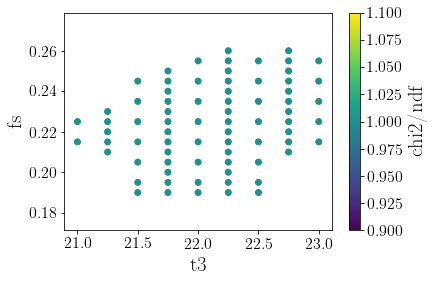

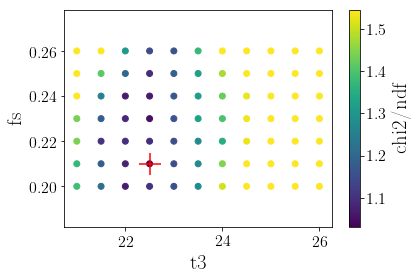

In [252]:
ding = pd.DataFrame(grids[0])
df = ddf_er[0]
ding['chi2'] = np.ones(len(ding))
plot_slice_containing_point(ding, 't3', 'fs', ding.iloc[20])
parslice_2d(df, 't3', 'fs')

# Pretty plots

## Eight panel plot

In [118]:
from matplotlib import gridspec

In [119]:
plt.style.use('latex_prl')
plt.rcParams['axes.labelsize'] = 24
plt.rcParams['font.size'] = 24
plt.rcParams['legend.fontsize'] = 24
plt.rcParams['xtick.labelsize'] = 16
plt.rcParams['ytick.labelsize'] = 16

/home/erik/anaconda3/envs/pax_new/lib/python3.4/site-packages/matplotlib/style/core.py:53: UserWarning: Style includes a parameter, 'backend', that is not related to style.  Ignoring
  "to style.  Ignoring".format(key))


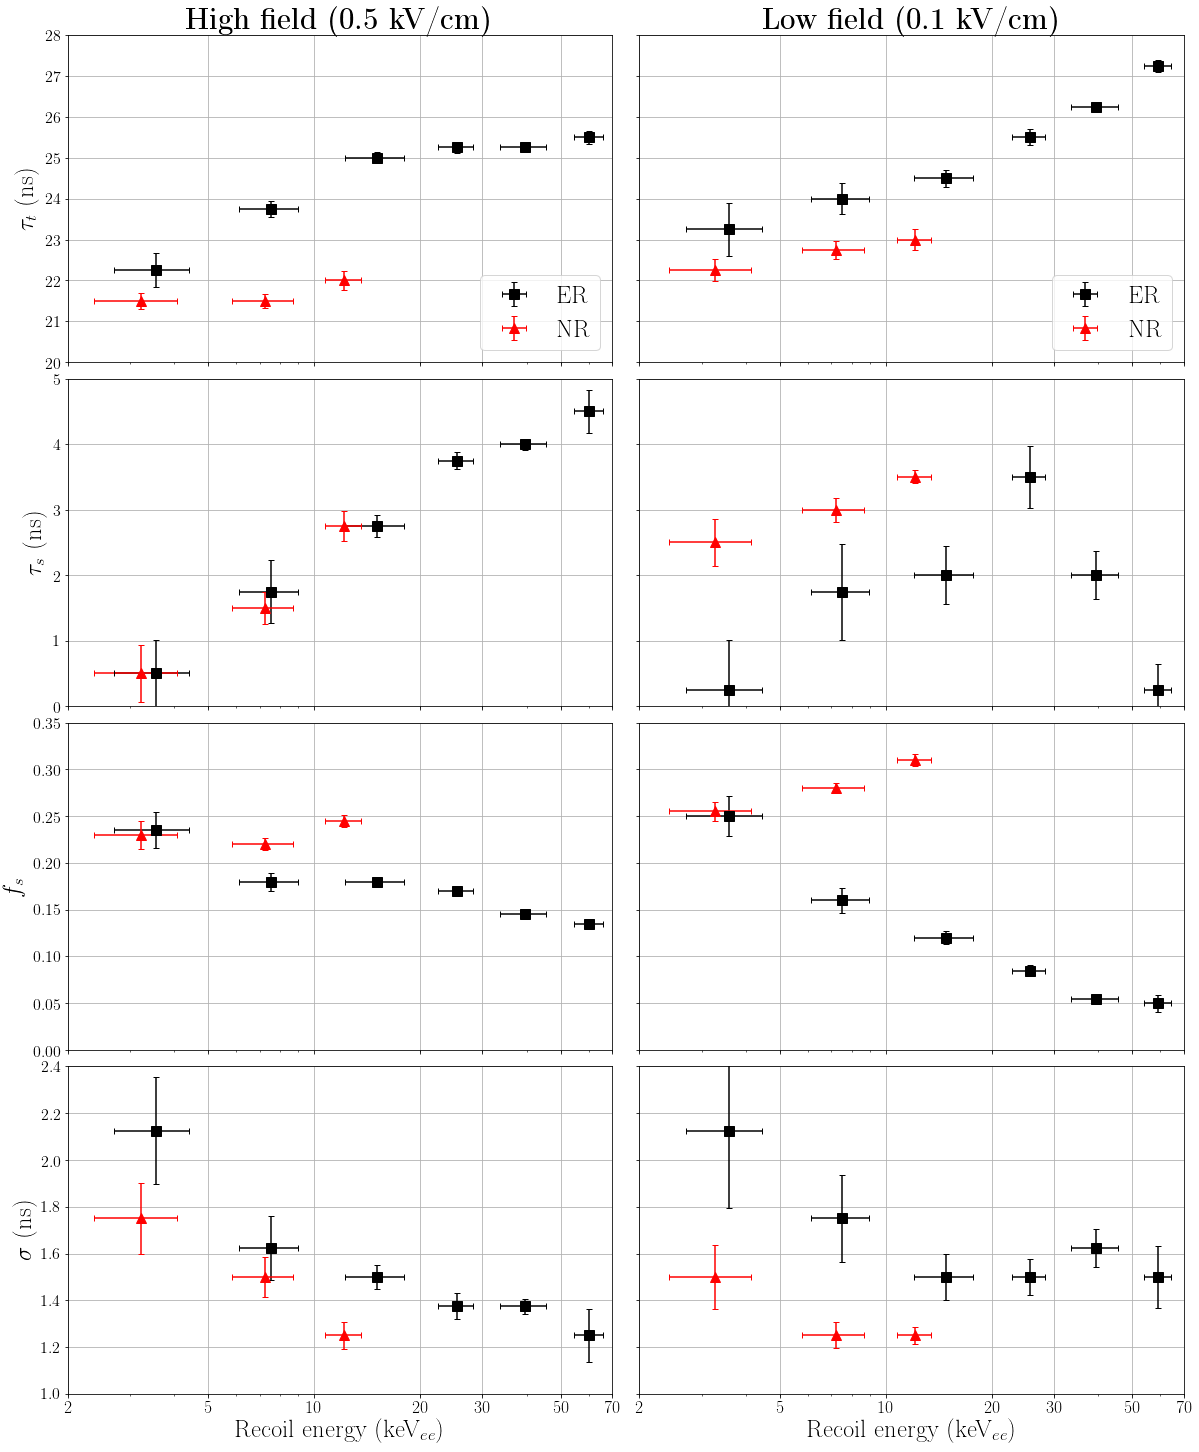

In [122]:
ms = 10 # markersize
cs = 3 # capsize for the error bars
xticks = [2, 5, 10, 20, 30, 50, 70]

f = plt.figure(figsize=(20,25))
gs = gridspec.GridSpec(4, 2, hspace = 0.05, wspace = 0.05) #width_ratios=[1,1,0.05], hspace=-50) 
ax0 = plt.subplot(gs[0])
ax1 = plt.subplot(gs[1])
ax2 = plt.subplot(gs[2])
ax3 = plt.subplot(gs[3])
ax4 = plt.subplot(gs[4])
ax5 = plt.subplot(gs[5])
ax6 = plt.subplot(gs[6])
ax7 = plt.subplot(gs[7])
axes = [ax0, ax1, ax2, ax3, ax4, ax5, ax6, ax7]

# Set grid and x limits
for ax in axes:
    ax.set_xlim(2, 70)
    ax.set_xscale('log')
    ax.set_xticks(xticks)
    ax.set_xticklabels([str(xtick) for xtick in xticks])
    ax.grid()
    

for ax in axes:
    if ax == ax6 or ax==ax7:
        continue
    ax.set_xticklabels([])

# Plot titles
ax0.set_title(r'\bf High field (0.5 kV/cm)')
ax1.set_title(r'\bf Low field (0.1 kV/cm)')

# x-axis titles
for ax in [ax6, ax7]:
    ax.set_xlabel('Recoil energy (keV$_{ee}$)')

# Turn off y-axis ticks for 
for ax in [ax1, ax3, ax5, ax7]:
    ax.set_ylabel("")
    ax.set_yticklabels([])

ax0.set_ylabel(r"$\tau_{t}$ (ns)")
ax2.set_ylabel(r"$\tau_{s}$ (ns)")
ax4.set_ylabel(r'$f_s$')
ax6.set_ylabel(r'$\sigma$ (ns)')

for x, l, c, marker in zip([x_er, x_nr], ['ER', 'NR'], ['black', 'red'], ['s', '^']):
    for ypar, ax in zip(['t3', 't1', 'fs', 'tts'], [ax0, ax2, ax4, ax6]):
        ax.errorbar(x['e'], xerr = x['de'], y = x[ypar], yerr = (x['d' + ypar + '+'], x['d' + ypar + '-']), 
                     label=l, marker = marker, markersize = ms, ls='None', capsize = cs, color=c)  
        
for x, l, c, marker in zip([x_er_l, x_nr_l], ['ER', 'NR'], ['black', 'red'], ['s', '^']):
    for ypar, ax in zip(['t3', 't1', 'fs', 'tts'], [ax1, ax3, ax5, ax7]):
        ax.errorbar(x['e'], xerr = x['de'], y = x[ypar], yerr = (x['d' + ypar + '+'], x['d' + ypar + '-']), 
                     label=l, marker = marker, markersize = ms, ls='None', capsize = cs, color=c)  

for ax in [ax0, ax1]:
    ax.set_ylim(20, 28)
for ax in [ax2, ax3]:
    ax.set_ylim(0, 5)
for ax in [ax4, ax5]:
    # Singlet fraction
    ax.set_ylim(0., 0.35)
for ax in [ax6, ax7]:
    # tts
    ax.set_ylim(1, 2.4)
    
for ax in axes:
#     if ax in [ax0, ax1, ax2, ax7]:
#         ax.legend(loc='lower right')
#     if ax in [ax4, ax6]:
#         ax.legend(loc='lower left')
#     if ax in [ax3]:
#         ax.legend(loc='upper right')
    if ax in [ax0, ax1]:
        ax.legend(loc='lower right')
    
plt.savefig('/home/erik/win/notes/giant_plotfig.pdf', bbox_inches='tight')

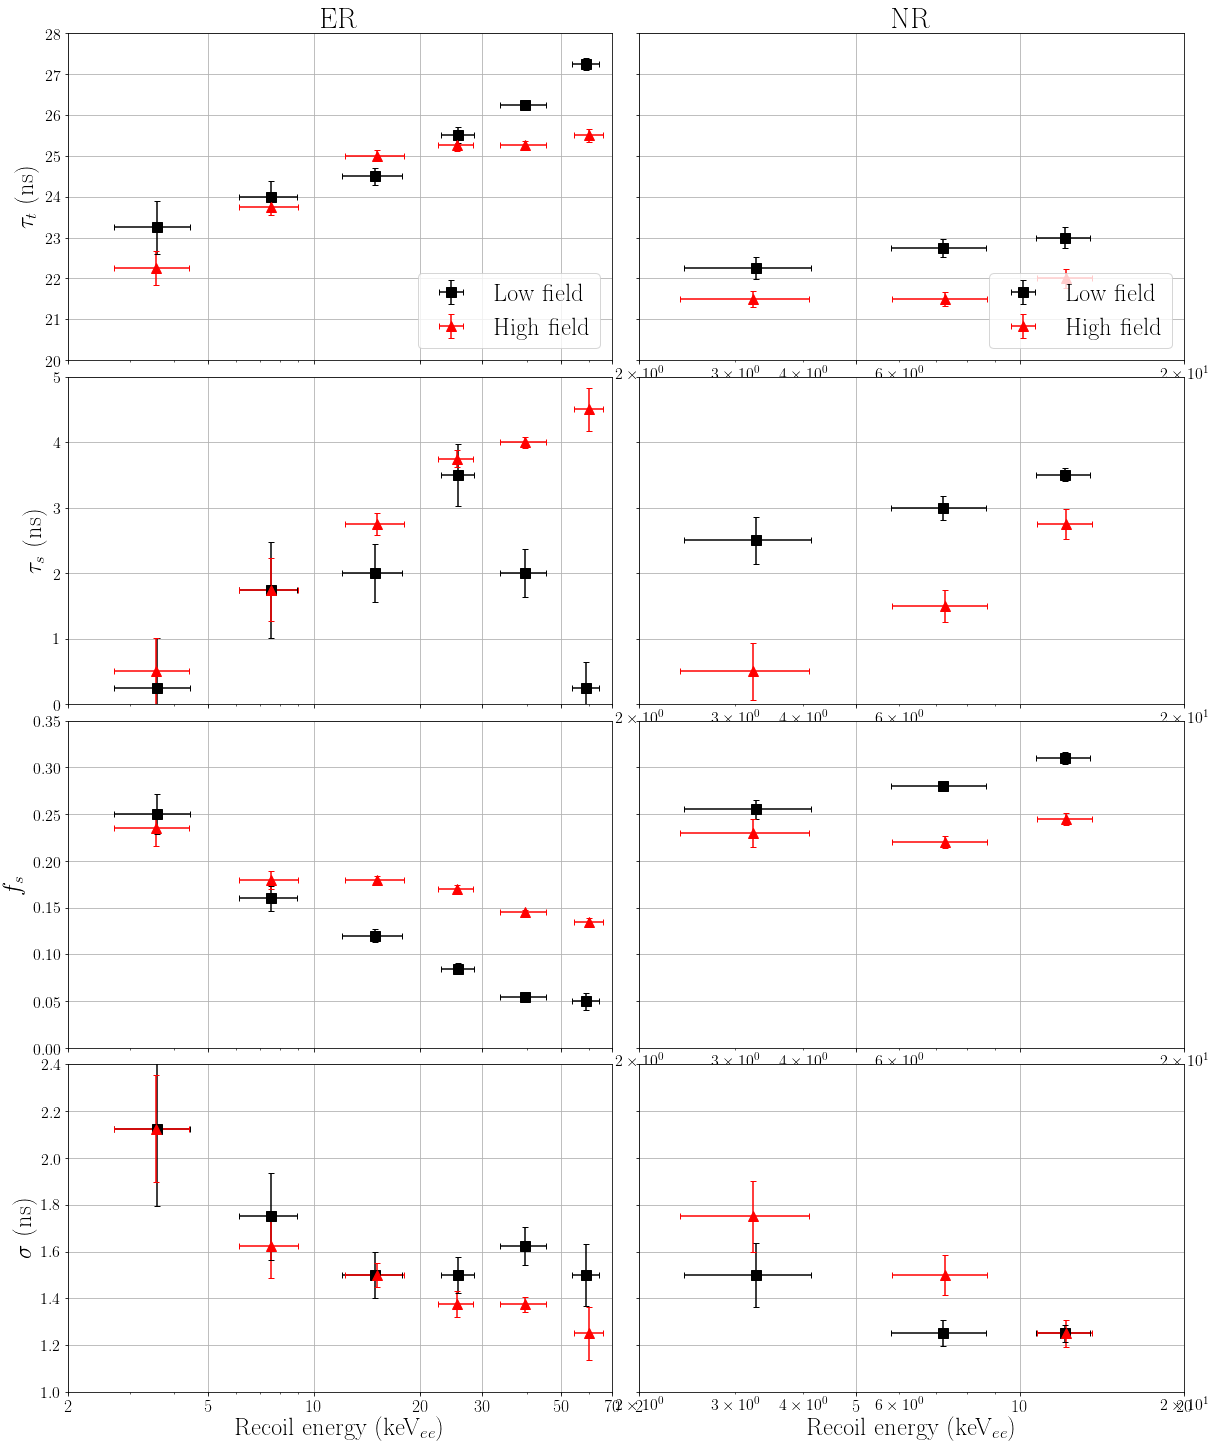

In [125]:
ms = 10 # markersize
cs = 3 # capsize for the error bars
xticks = [2, 5, 10, 20, 30, 50, 70]

f = plt.figure(figsize=(20,25))
gs = gridspec.GridSpec(4, 2, hspace = 0.05, wspace = 0.05) #width_ratios=[1,1,0.05], hspace=-50) 
ax0 = plt.subplot(gs[0])
ax1 = plt.subplot(gs[1])
ax2 = plt.subplot(gs[2])
ax3 = plt.subplot(gs[3])
ax4 = plt.subplot(gs[4])
ax5 = plt.subplot(gs[5])
ax6 = plt.subplot(gs[6])
ax7 = plt.subplot(gs[7])
axes = [ax0, ax1, ax2, ax3, ax4, ax5, ax6, ax7]

# Set grid and x limits
for ax in axes:
    ax.set_xlim(2, 70)
    ax.set_xscale('log')
    ax.set_xticks(xticks)
    ax.set_xticklabels([str(xtick) for xtick in xticks])
    ax.grid()
    
for ax in [ax1, ax3, ax5, ax7]:
    ax.set_xlim(2, 20)

for ax in axes:
    if ax == ax6 or ax==ax7:
        continue
    ax.set_xticklabels([])

# Plot titles
ax0.set_title(r'ER')
ax1.set_title(r'NR')

# x-axis titles
for ax in [ax6, ax7]:
    ax.set_xlabel('Recoil energy (keV$_{ee}$)')

# Turn off y-axis ticks for 
for ax in [ax1, ax3, ax5, ax7]:
    ax.set_ylabel("")
    ax.set_yticklabels([])

ax0.set_ylabel(r"$\tau_{t}$ (ns)")
ax2.set_ylabel(r"$\tau_{s}$ (ns)")
ax4.set_ylabel(r'$f_s$')
ax6.set_ylabel(r'$\sigma$ (ns)')

for x, l, c, marker in zip([x_er_l, x_er], ['Low field', 'High field'], ['black', 'red'], ['s', '^']):
    for ypar, ax in zip(['t3', 't1', 'fs', 'tts'], [ax0, ax2, ax4, ax6]):
        ax.errorbar(x['e'], xerr = x['de'], y = x[ypar], yerr = (x['d' + ypar + '+'], x['d' + ypar + '-']), 
                     label=l, marker = marker, markersize = ms, ls='None', capsize = cs, color=c)  
        
for x, l, c, marker in zip([x_nr_l, x_nr], ['Low field', 'High field'], ['black', 'red'], ['s', '^']):
    for ypar, ax in zip(['t3', 't1', 'fs', 'tts'], [ax1, ax3, ax5, ax7]):
        ax.errorbar(x['e'], xerr = x['de'], y = x[ypar], yerr = (x['d' + ypar + '+'], x['d' + ypar + '-']), 
                     label=l, marker = marker, markersize = ms, ls='None', capsize = cs, color=c)  

for ax in [ax0, ax1]:
    ax.set_ylim(20, 28)
for ax in [ax2, ax3]:
    ax.set_ylim(0, 5)
for ax in [ax4, ax5]:
    # Singlet fraction
    ax.set_ylim(0., 0.35)
for ax in [ax6, ax7]:
    # tts
    ax.set_ylim(1, 2.4)
    
for ax in axes:
#     if ax in [ax0, ax1, ax2, ax7]:
#         ax.legend(loc='lower right')
#     if ax in [ax4, ax6]:
#         ax.legend(loc='lower left')
#     if ax in [ax3]:
#         ax.legend(loc='upper right')
    if ax in [ax0, ax1]:
        ax.legend(loc='lower right')
    
plt.savefig('/home/erik/win/notes/giant_plotfig_ernr.pdf', bbox_inches='tight')

## Fit example

This requires the four-fit data to have been read, and the ddf from `Read all four-fit data` 

In [53]:
df = ddf_er[2]

In [155]:
plt.style.use('latex_prl')
plt.rcParams['axes.labelsize'] = 20
plt.rcParams['font.size'] = 18
plt.rcParams['legend.fontsize'] = 20
plt.rcParams['xtick.labelsize'] = 16
plt.rcParams['ytick.labelsize'] = 16

/home/erik/anaconda3/envs/pax_new/lib/python3.4/site-packages/matplotlib/style/core.py:53: UserWarning: Style includes a parameter, 'backend', that is not related to style.  Ignoring
  "to style.  Ignoring".format(key))


In [208]:
import matplotlib as mpl
def fancyplot(**params):
    gridalpha = 0.3
    
    params = get_params(params)
    sigmas = get_sigma(**params)
    model = params['model']
    ydata = params['ydata']
    scale = 1/np.max(ydata)

    # large subplot
    ax2 = plt.subplot2grid((3,1), (2,0))
    ax1 = plt.subplot2grid((3,1), (0,0), rowspan=2, sharex=ax2)

    plt.sca(ax1)
    plt.fill_between(spe_ts, scale * (model - sigmas), scale * (model + sigmas),
                     alpha=0.5, linewidth=0, step='mid')
    plt.plot(spe_ts, scale * model, linestyle='steps-mid', label='Model')
    plt.plot(spe_ts, scale * ydata, marker='.', linestyle='', markersize=3, c='k', label='Observed')

    plt.grid(alpha=gridalpha, linestyle='-', which='both')
    plt.setp(ax1.get_xticklabels(), visible=False)
    plt.ylabel("Fraction of amplitude")
    plt.axhline(0, c='k', alpha=0.5)
    leg = plt.legend(loc='upper right', numpoints=1)
    leg.get_frame().set_linewidth(0.0)
    leg.get_frame().set_alpha(0.5)
    leg.legendHandles[1]._legmarker.set_markersize(8)
    plt.ylim(0, None)
    plt.title(r'\bf{Electronic recoil, %d - %d keV}' % (params['e_min'], params['e_max']))
    plt.gca().xaxis.set_major_locator(mpl.ticker.MaxNLocator(prune='lower'))
    
    # Add residuals
    plt.sca(ax2)
    plt.subplot2grid((3,1), (2,0), sharex=ax1)
#     plt.xlim(-12, 150)
#     for _l in (params['t_min'], params['t_max']):
#         plt.axvline(_l)
    plt.xlim(params['t_min'], params['t_max'])

    res = (ydata - model) / sigmas # residuals(ydata, minus, base, plus, **params)
    
    plt.plot(spe_ts, res, marker='x', ls='None', c='k', markersize=5)
    plt.plot(spe_ts, res, ls='--', c='k', alpha = 0.5)

    plt.grid(which='both', linestyle='-', alpha=gridalpha)
    plt.axhline(0, c='k', alpha=0.5)
    plt.ylim(-3, 3)
    for pol in [+1, -1]:
        plt.axhline(pol * 1, ls='--', color='k', alpha=0.25)
        plt.axhline(pol * 2, ls='solid', color='k', alpha=0.25)

    plt.ylabel("Residual")
    plt.xlabel("Time (ns)")
    plt.gcf().subplots_adjust(0,0,1,1,0,0)
    ax1.get_yaxis().set_label_coords(-0.067 ,0.5)
    # ax2.get_yaxis().set_label_coords(0, 0.5)
    


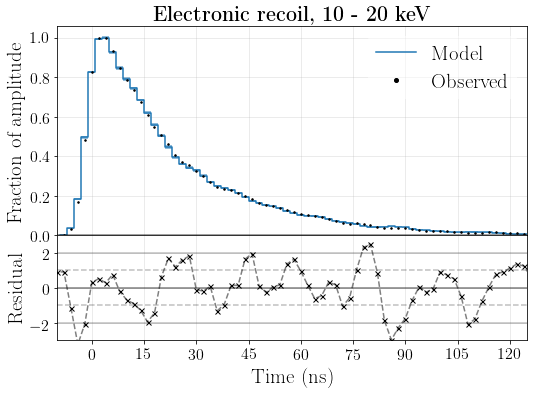

In [209]:
fancyplot(**minvalue(df, to_input=True))
plt.savefig('pulsefit.pdf', bbox_inches='tight')

In [298]:
def fancylong(**params):
    gridalpha = 0.3
    h_bottom = 0.15
    h_top = (0.8 - h_bottom)/2

    params = get_params(params)
    sigmas = get_sigma(**params)
    model = params['model']
    ydata = params['ydata']
    scale = 1/np.max(ydata)
    xlim = (params['t_min'], params['t_max'])

    plt.figure(figsize = (6.531496194824962, 2* 4.3543307965499745)) # Double height figure
    
    #### FRAME 1
    frame1=plt.gcf().add_axes((.1,0.1 + h_top + h_bottom,.8, h_top))
    plt.fill_between(spe_ts, scale * (model - sigmas), scale * (model + sigmas),
                     alpha=0.5, linewidth=0, step='mid', label='Uncertainty')
    plt.plot(spe_ts, scale * model, linestyle='steps-mid', label='Model')
    plt.plot(spe_ts, scale * ydata, marker='.', linestyle='', markersize=3, c='k', label='Observed')
    plt.grid(alpha=gridalpha, linestyle='-', which='both')
    plt.setp(frame1.get_xticklabels(), visible=False)
    plt.axhline(0, c='k', alpha=0.5)
    handles, labels =  frame1.get_legend_handles_labels()
    labels = [labels[0], labels[2], labels[1]]
    handles = [handles[0], handles[2],handles[1]]
    leg = plt.legend(handles, labels, loc='upper right', numpoints=1)
    leg.get_frame().set_linewidth(0.0)
    leg.get_frame().set_alpha(0.5)
    leg.legendHandles[2]._legmarker.set_markersize(8)
    plt.ylim(0, 1.1)
    plt.title(r'\bf{Electronic recoil, %d - %d keV}' % (params['e_min'], params['e_max']))
    plt.yticks(np.arange(0.2, 1.2, 0.2))

    plt.xlim(xlim)
    #### FRAME 2
    frame2=plt.gcf().add_axes((.1,0.1 + h_bottom,.8, h_top))
    plt.fill_between(spe_ts, scale * (model - sigmas), scale * (model + sigmas),
                     alpha=0.5, linewidth=0, step='mid')
    plt.plot(spe_ts, scale * model, linestyle='steps-mid', label='Model')
    plt.plot(spe_ts, scale * ydata, marker='.', linestyle='', markersize=3, c='k', label='Observed')

    plt.grid(alpha=gridalpha, linestyle='-', which='both')
    plt.setp(frame2.get_xticklabels(), visible=False)
    plt.ylabel("Fraction of amplitude")
    plt.axhline(0, c='k', alpha=0.5)
    plt.yscale('log')
    plt.gca().xaxis.set_major_locator(mpl.ticker.MaxNLocator(prune='lower'))
    plt.xlim(xlim)
    plt.xticks(np.arange(0, 140, 20))
    plt.ylim(5e-4, 1.2)
    frame3=plt.gcf().add_axes((.1,.1,.8, h_bottom))
    res = (ydata - model) / sigmas # residuals(ydata, minus, base, plus, **params)
    
    plt.plot(spe_ts, res, marker='x', ls='None', c='k', markersize=5)
    plt.plot(spe_ts, res, ls='--', c='k', alpha = 0.5)

    plt.grid(which='both', linestyle='-', alpha=gridalpha)
    plt.axhline(0, c='k', alpha=0.5)
    plt.ylim(-3, 3)
    plt.xlim(xlim)
    plt.yticks([-2, -1, 0, 1, 2])
    for pol in [+1, -1]:
        plt.axhline(pol * 1, ls='--', color='k', alpha=0.25)
        plt.axhline(pol * 2, ls='solid', color='k', alpha=0.25)

    plt.ylabel("Residual")
    plt.xlabel("Time (ns)")
    
    frame2.get_yaxis().set_label_coords(-0.10 , 1)
    frame3.get_yaxis().set_label_coords(-0.10 , 0.5)
    print(params['chi2'])

1.56593348767


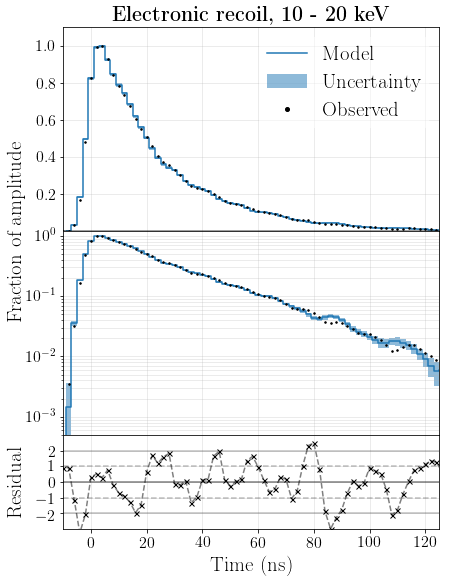

In [299]:
fancylong(**minvalue(df, to_input=True))
# plt.savefig('pulsefit.pdf', bbox_inches='tight')

## Chi2 evolution

In [106]:
plt.style.use('latex_prl')
plt.rcParams['axes.labelsize'] = 20
plt.rcParams['font.size'] = 18
plt.rcParams['legend.fontsize'] = 20
plt.rcParams['xtick.labelsize'] = 16
plt.rcParams['ytick.labelsize'] = 16

/home/erik/anaconda3/envs/pax_new/lib/python3.4/site-packages/matplotlib/style/core.py:53: UserWarning: Style includes a parameter, 'backend', that is not related to style.  Ignoring
  "to style.  Ignoring".format(key))


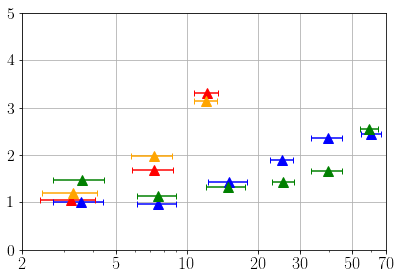

In [114]:
ms = 10 # markersize
cs = 3 # capsize for the error bars
xticks = [2, 5, 10, 20, 30, 50, 70]

for x, l, c in zip([x_er, x_nr, x_er_l, x_nr_l], ['ER', 'NR', 'ER_l', 'NR_l'], ['blue', 'red', 'green', 'orange']):
    plt.errorbar(x['e'], x['chi2'], xerr=x['de'], # yerr=x['dchi2'],
                 label=l, marker = marker, markersize = ms, ls='None', capsize = cs, color=c)
    
plt.xlim(2, 70)
plt.xscale('log')
plt.xticks(xticks)
plt.gca().set_xticklabels([str(xtick) for xtick in xticks])
plt.grid()
plt.ylim(0, 5)
# plt.legend()
plt.show()

# Improvements (R&D section)

## Super fit

In [104]:
df = read_pickles(data_dir, 'er_50_70_recomb2')

Read 30870 datapoints from 61 files.


In [105]:
import matplotlib.pyplot as plt
%matplotlib inline

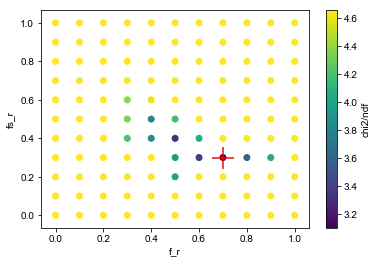

In [109]:
parslice_2d(df1, 'f_r', 'fs_r')

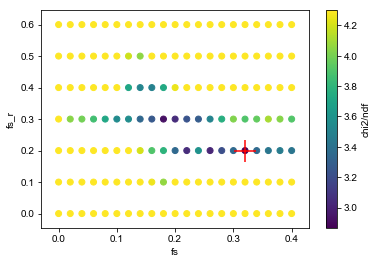

In [111]:
parslice_2d(df, 'fs', 'fs_r')

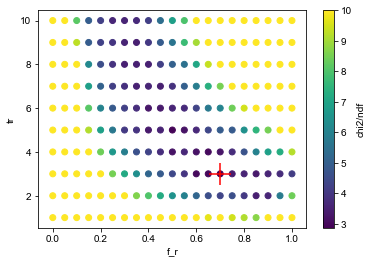

In [117]:
parslice_2d(df, 'f_r', 'tr', vmax=10)

In [123]:
ding = df['chi2'].values

In [126]:
ding = ding[np.invert(np.isnan(ding))]

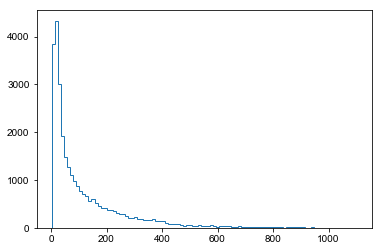

In [128]:
plt.hist(ding, bins=100, histtype='step')
plt.show()

In [115]:
minval

{'chi2': 2.8662572479744401,
 'dset': 'er',
 'e_max': 70,
 'e_min': 50,
 'f_r': 0.70000000000000007,
 'fs': 0.32000000000000001,
 'fs_r': 0.19999999999999998,
 'n_photons': 1000000,
 's1_model': 'recombination',
 'stored_stat': True,
 't1': 2.0,
 't3': 21.5,
 'tr': 3.0,
 'tts': 1.5}

In [93]:
df[(df['f_r'] > 0.699) & (df['f_r'] < 0.701)]

chi2 dset  e_max  e_min  f_r   fs  fs_r  \
9317     73.295811   er     70     50  0.7  0.0   0.0   
9318    190.227476   er     70     50  0.7  0.0   0.0   
9319    323.495981   er     70     50  0.7  0.0   0.0   
9320    450.228278   er     70     50  0.7  0.0   0.0   
9321    573.799714   er     70     50  0.7  0.0   0.0   
9322    633.741691   er     70     50  0.7  0.0   0.0   
9323    730.944182   er     70     50  0.7  0.0   0.0   
9324    912.153393   er     70     50  0.7  0.0   0.0   
9325   1078.858943   er     70     50  0.7  0.0   0.0   
9326   1201.830949   er     70     50  0.7  0.0   0.0   
9327   1137.422435   er     70     50  0.7  0.0   0.0   
9328     26.506463   er     70     50  0.7  0.0   0.1   
9329    103.092110   er     70     50  0.7  0.0   0.1   
9330    215.120488   er     70     50  0.7  0.0   0.1   
9331    320.741142   er     70     50  0.7  0.0   0.1   
9332    448.436815   er     70     50  0.7  0.0   0.1   
9333    493.016719   er     70     50  0.7  0.0   0.1   
9334    637.407848   er     70     50  0.7  0.0   0.1   
9335    716.142114   er     70     50  0.7  0.0   0.1   
9336    864.984173   er     70     50  0.7  0.0   0.1   
9337    917.821512   er     70     50  0.7  0.0   0.1   
9338   1060.122635   er     70     50  0.7  0.0   0.1   
9339      8.220013   er     70     50  0.7  0.0   0.2   
9340     41.720903   er     70     50  0.7  0.0   0.2   
9341    122.497684   er     70     50  0.7  0.0   0.2   
9342    199.870478   er     70     50  0.7  0.0   0.2   
9343    305.598089   er     70     50  0.7  0.0   0.2   
9344    373.924315   er     70     50  0.7  0.0   0.2   
9345    496.880945   er     70     50  0.7  0.0   0.2   
9346    546.266038   er     70     50  0.7  0.0   0.2   
...            ...  ...    ...    ...  ...  ...   ...   
36661   267.436774   er     70     50  0.7  0.4   0.4   
36662   151.881290   er     70     50  0.7  0.4   0.4   
36663    97.235982   er     70     50  0.7  0.4   0.4   
36664    47.395613   er     70     50  0.7  0.4   0.4   
36665    27.436544   er     70     50  0.7  0.4   0.4   
36666    15.108295   er     70     50  0.7  0.4   0.4   
36667    12.689646   er     70     50  0.7  0.4   0.4   
36668    18.899714   er     70     50  0.7  0.4   0.4   
36669    30.920112   er     70     50  0.7  0.4   0.4   
36670    43.097391   er     70     50  0.7  0.4   0.4   
36671   391.262496   er     70     50  0.7  0.4   0.5   
36672   277.232412   er     70     50  0.7  0.4   0.5   
36673   163.212018   er     70     50  0.7  0.4   0.5   
36674   114.551627   er     70     50  0.7  0.4   0.5   
36675    70.391358   er     70     50  0.7  0.4   0.5   
36676    45.505597   er     70     50  0.7  0.4   0.5   
36677    28.660367   er     70     50  0.7  0.4   0.5   
36678    19.445382   er     70     50  0.7  0.4   0.5   
36679    18.475781   er     70     50  0.7  0.4   0.5   
36680    23.615597   er     70     50  0.7  0.4   0.5   
36681   581.584368   er     70     50  0.7  0.4   0.6   
36682   420.739713   er     70     50  0.7  0.4   0.6   
36683   297.383805   er     70     50  0.7  0.4   0.6   
36684   214.342039   er     70     50  0.7  0.4   0.6   
36685   145.693243   er     70     50  0.7  0.4   0.6   
36686   104.503742   er     70     50  0.7  0.4   0.6   
36687    68.926069   er     70     50  0.7  0.4   0.6   
36688    46.923212   er     70     50  0.7  0.4   0.6   
36689    33.572238   er     70     50  0.7  0.4   0.6   
36690    25.795648   er     70     50  0.7  0.4   0.6   

                                                   model  n_photons  \
9317   [5.04278836172e-05, 6.64480166456e-05, 7.62985...    1000000   
9318   [4.86000717604e-05, 6.08964960707e-05, 6.96333...    1000000   
9319   [4.6985911913e-05, 5.75278593635e-05, 6.565069...    1000000   
9320   [4.60073643529e-05, 5.52492932017e-05, 6.27590...    1000000   
9321   [4.49722116678e-05, 5.34703057203e-05, 6.04372...    1000000   
9322   [4.44929977429e-05, 5.23919242437e-05, 5.88562

In [130]:
p0 = {}

In [131]:
default_params['stored_stat_value'] = real_s1_wv_sigma(**p0)

In [139]:
%%time
gof(n_photons=int(1e6))

gof=4.8246944968905465, fs=0.2, t1=3.1, t3=24, tts=2.0
CPU times: user 15.1 s, sys: 3.83 s, total: 18.9 s
Wall time: 8.02 s


4.8246944968905465

## Super fit er zero

In [30]:
ddf_er_0_rec = read_and_combine_energy_bins(data_dir, ['er_0_recomb', 'er_0_recomb2', 'er_0_f_rec'], [10, 20, 30, 40, 50])

Read 33033 datapoints from 22 files.
Read 15246 datapoints from 10 files.
Read 6380 datapoints from 21 files.
Removing 54658 of 54659 items, already exist...
Read 35574 datapoints from 23 files.
Found no filenames for base er_0_recomb2_20_30, skipping...
Read 6581 datapoints from 21 files.
Removing 42154 of 42155 items, already exist...
Read 35574 datapoints from 23 files.
Found no filenames for base er_0_recomb2_30_40, skipping...
Read 6533 datapoints from 21 files.
Removing 42106 of 42107 items, already exist...
Read 33033 datapoints from 22 files.
Read 15246 datapoints from 10 files.
Read 6597 datapoints from 21 files.
Removing 54875 of 54876 items, already exist...


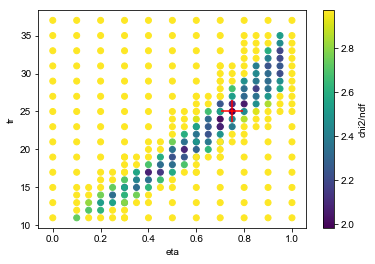

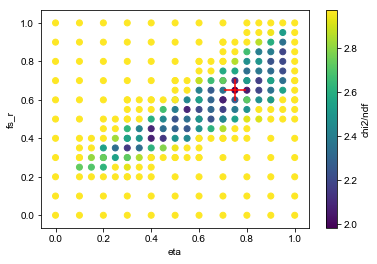

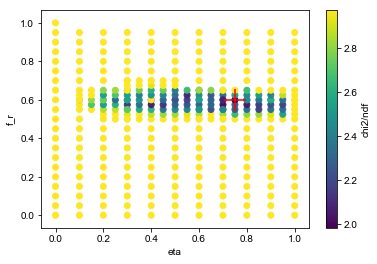

In [34]:
plot_all_slices_rec(ddf_er_0_rec[1])

In [128]:
p = minvalue(df, to_input=True)

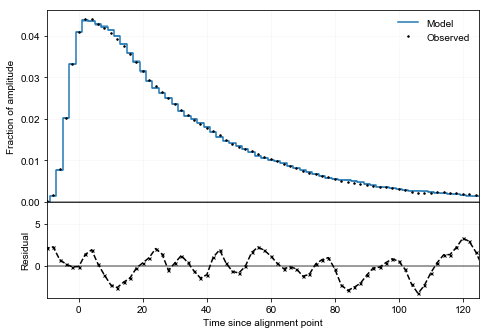

chi2 = 2.186705


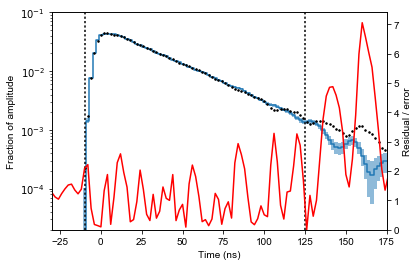

In [129]:
plot_model_manual(**p)

In [53]:
res = [minvalue(df) for df in ddf]

In [54]:
res = pd.DataFrame(res)

In [55]:
res

chi2  dset  e_max  e_min  eta   f_r    fs  fs_r  n_photons  \
0  1.795434  er_0     20     10  0.8  0.45  0.23   0.7    1000000   
1  2.073427  er_0     30     20  0.7  0.60  0.23   0.6    1000000   
2  1.850635  er_0     40     30  0.3  0.70  0.23   0.4    1000000   
3  2.186705  er_0     50     40  0.9  0.70  0.23   0.7    1000000   

        s1_model stored_stat   t1    t3    tr  tts  
0  recombination        True  1.5  21.5  29.0  1.5  
1  recombination        True  1.5  21.5  23.0  1.5  
2  recombination        True  1.5  21.5  15.0  1.5  
3  recombination        True  1.5  21.5  29.0  1.5

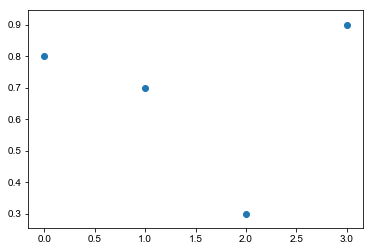

In [58]:
plt.scatter(res.index, res.eta)

### Fine grid rec

In [48]:
ddf_er_0_rec[0]['n_photons']

0          20000
1          20000
2          20000
3          20000
4          20000
5          20000
6          20000
7          20000
8          20000
9          20000
10         20000
11         20000
12         20000
13         20000
14         20000
15         20000
16         20000
17         20000
18         20000
19         20000
20         20000
21         20000
22         20000
23         20000
24         20000
25         20000
26         20000
27         20000
28         20000
29         20000
          ...   
48249    1000000
48250    1000000
48251    1000000
48252    1000000
48253    1000000
48254    1000000
48255    1000000
48256    1000000
48257    1000000
48258    1000000
48259    1000000
48260    1000000
48261    1000000
48262    1000000
48263    1000000
48264    1000000
48265    1000000
48266    1000000
48267    1000000
48268    1000000
48269    1000000
48270    1000000
48271    1000000
48272    1000000
48273    1000000
48274    1000000
48275    1000000
48276    10000

In [49]:
for df in ddf_er_0_rec:
    df['n_photons'] = int(1e6)

In [50]:
ddf_er_0_rec[0]

chi2  dset  e_max  e_min  eta  f_r    fs  fs_r  \
0      145.830641  er_0     20     10  0.0  0.0  0.23   0.0   
1      162.416814  er_0     20     10  0.0  0.0  0.23   0.0   
2      122.159582  er_0     20     10  0.0  0.0  0.23   0.0   
3      111.768440  er_0     20     10  0.0  0.0  0.23   0.0   
4      141.056402  er_0     20     10  0.0  0.0  0.23   0.0   
5      129.482005  er_0     20     10  0.0  0.0  0.23   0.0   
6       98.265305  er_0     20     10  0.0  0.0  0.23   0.0   
7      135.483483  er_0     20     10  0.0  0.0  0.23   0.0   
8      143.076105  er_0     20     10  0.0  0.0  0.23   0.0   
9      121.380276  er_0     20     10  0.0  0.0  0.23   0.0   
10     109.292968  er_0     20     10  0.0  0.0  0.23   0.0   
11     121.670747  er_0     20     10  0.0  0.0  0.23   0.0   
12     133.437614  er_0     20     10  0.0  0.0  0.23   0.0   
13     123.796906  er_0     20     10  0.0  0.0  0.23   0.1   
14     137.652483  er_0     20     10  0.0  0.0  0.23   0.1   
15     112.770507  er_0     20     10  0.0  0.0  0.23   0.1   
16     123.691462  er_0     20     10  0.0  0.0  0.23   0.1   
17     122.075909  er_0     20     10  0.0  0.0  0.23   0.1   
18     125.659980  er_0     20     10  0.0  0.0  0.23   0.1   
19     111.026574  er_0     20     10  0.0  0.0  0.23   0.1   
20     160.411733  er_0     20     10  0.0  0.0  0.23   0.1   
21     121.573293  er_0     20     10  0.0  0.0  0.23   0.1   
22     117.021690  er_0     20     10  0.0  0.0  0.23   0.1   
23     137.713527  er_0     20     10  0.0  0.0  0.23   0.1   
24     101.766150  er_0     20     10  0.0  0.0  0.23   0.1   
25     134.677478  er_0     20     10  0.0  0.0  0.23   0.1   
26     114.901688  er_0     20     10  0.0  0.0  0.23   0.2   
27     123.243314  er_0     20     10  0.0  0.0  0.23   0.2   
28     115.331141  er_0     20     10  0.0  0.0  0.23   0.2   
29     115.757059  er_0     20     10  0.0  0.0  0.23   0.2   
...           ...   ...    ...    ...  ...  ...   ...   ...   
48249         NaN  er_0     20     10  1.0  1.0  0.23   0.6   
48250         NaN  er_0     20     10  1.0  1.0  0.23   0.6   
48251         NaN  er_0     20     10  1.0  1.0  0.23   0.6   
48252         NaN  er_0     20     10  1.0  1.0  0.23   0.6   
48253         NaN  er_0     20     10  1.0  1.0  0.23   0.6   
48254         NaN  er_0     20     10  1.0  1.0  0.23   0.6   
48255         NaN  er_0     20     10  1.0  1.0  0.23   0.7   
48256         NaN  er_0     20     10  1.0  1.0  0.23   0.7   
48257         NaN  er_0     20     10  1.0  1.0  0.23   0.7   
48258         NaN  er_0     20     10  1.0  1.0  0.23   0.7   
48259         NaN  er_0     20     10  1.0  1.0  0.23   0.7   
48260         NaN  er_0     20     10  1.0  1.0  0.23   0.7   
48261         NaN  er_0     20     10  1.0  1.0  0.23   0.8   
48262         NaN  er_0     20     10  1.0  1.0  0.23   0.8   
48263         NaN  er_0     20     10  1.0  1.0  0.23   0.8   
48264         NaN  er_0     20     10  1.0  1.0  0.23   0.8   
48265         NaN  er_0     20     10  1.0  1.0  0.23   0.8   
48266         NaN  er_0     20     10  1.0  1.0  0.23   0.8   
48267         NaN  er_0     20     10  1.0  1.0  0.23   0.9   
48268         NaN  er_0     20     10  1.0  1.0  0.23   0.9   
48269         NaN  er_0     20     10  1.0  1.0  0.23   0.9   
48270         NaN  er_0     20     10  1.0  1.0  0.23   0.9   
48271         NaN  er_0     20     10  1.0  1.0  0.23   0.9   
48272         NaN  er_0     20     10  1.0  1.0  0.23   0.9   
48273         NaN  er_0     20     10  1.0  1.0  0.23   1.0   
48274         NaN  er_0     20     10  1.0  1.0  0.23   1.0   
48275         NaN  er_0     20     10  1.0  1.0  0.23   1.0   
48276         NaN  er_0     20     10  1.0  1.0  0.23   1.0   
48277         NaN  er_0     20     10  1.0  1.0  0.23   1.0   
48278         NaN  er_0     20     10  1.0  1.0  0.23   1.0   

                                                   model  n_photons  \
0      [5.16436206464e-05, 9.198507

In [51]:
grids = []
for ddf, dset in zip([ddf_er_0_rec], ['er_0']): # zip([ddf_er_l, ddf_nr_l], ['er_l', 'nr_l']):# zip([ddf_er, ddf_nr, ddf_er_l], ['er', 'nr', 'er_l']):
    for df in ddf:
        finegrid = build_fine_grid(df, 20, ['eta', 'f_r',  'fs_r', 'tr'], [0.1, 0.05, 0.1,  2.],
                                  keys_to_copy = ['dset', 'e_min', 'e_max', 'n_photons','s1_model', #oops 
                                                 't1', 't3', 'fs', 'tts'])
        finegrid = pd.DataFrame(finegrid)
        finegrid = remove_common(finegrid, df, key_list = ['eta', 'f_r',  'fs_r', 'tr'])
        finegrid = finegrid.to_dict('records')
        grids.append(finegrid)
        # One element
        el = df.iloc[0]
        fn = '/data/xenon/ehogenbi/pulsefit/finegrid/%s_%02d_%02d_fine_rec.pickle' % (el['dset'], el['e_min'], el['e_max'])
        print('Dumping %d elements to %s' % (len(finegrid), fn))
        with open(fn, 'wb') as f:
            pickle.dump(finegrid, f)

Selected 20 values with chi2 ranging from 1.80 to 2.13...
Removed 5355 of 12500 settings that were nonunique, 7145 left...
Also removed 0 points with zero t1 or tts, 7145 left!
Removing 765 of 7145 items, already exist...
Dumping 6380 elements to /data/xenon/ehogenbi/pulsefit/finegrid/er_0_10_20_fine_rec.pickle
Selected 20 values with chi2 ranging from 2.07 to 2.75...
Removed 5097 of 12500 settings that were nonunique, 7403 left...
Also removed 0 points with zero t1 or tts, 7403 left!
Removing 822 of 7403 items, already exist...
Dumping 6581 elements to /data/xenon/ehogenbi/pulsefit/finegrid/er_0_20_30_fine_rec.pickle
Selected 20 values with chi2 ranging from 1.85 to 2.70...
Removed 5157 of 12500 settings that were nonunique, 7343 left...
Also removed 0 points with zero t1 or tts, 7343 left!
Removing 810 of 7343 items, already exist...
Dumping 6533 elements to /data/xenon/ehogenbi/pulsefit/finegrid/er_0_30_40_fine_rec.pickle
Selected 20 values with chi2 ranging from 2.19 to 3.31...
Rem

In [57]:
grids[4]

IndexError: list index out of range

## Interpretation of chi2 thing

In [450]:
ndf = 20
offset = 2.5
sigma = 2

def get_chi2(ndf, sigma, f_real, preal, f_fit, x0, xreal, plot=False, ret = 'ratio'):    
    t       = np.linspace(0, 100, ndf)
    err_est = np.ones(ndf) * sigma
    y = f_real(t, **preal)
    dy = np.random.normal(loc=0, scale=sigma, size=ndf)
    y = y + dy
    
    if plot:
        plt.plot(t, y)
    truefit = np.sum(((y - f_fit(t, xreal)) / err_est)**2) / ndf
    if ret == 'truevalue':
        return truefit
    
    optres = scipy.optimize.minimize(lambda x : np.sum(((y - f_fit(t, x)) / err_est)**2) / ndf, x0).fun
    return truefit / optres


In [387]:
(126 + 2) /2

64.0

In [388]:
def const(x, a):
    return a

In [413]:
get_chi2(64, 1, const, {'a':1}, const, 2)

2.2002291566520271

In [435]:
chi2s = [get_chi2(64, 1, const, {'a':1}, const, 2, 1) for _ in range(10000)]

Cutoff at 1.015860


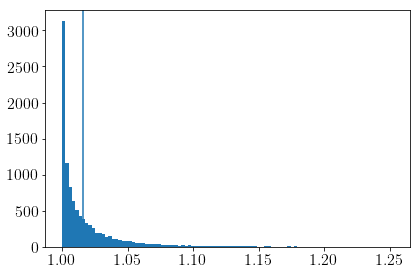

In [436]:
plt.hist(chi2s, bins=100)
cutoff = np.percentile(chi2s, 68)
plt.axvline(cutoff)
print('Cutoff at %f' % cutoff)
plt.show()

In [454]:
chi2s = [get_chi2(6, 1, const, {'a':1}, const, 2, 1) for _ in range(10000)]

Cutoff at 1.241256


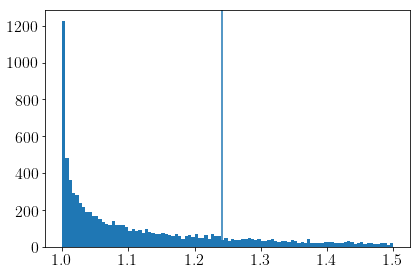

In [456]:
plt.hist(chi2s, bins=100, range=(1, 1.5))
cutoff = np.percentile(chi2s, 68)
plt.axvline(cutoff)
print('Cutoff at %f' % cutoff)
plt.show()

In [422]:
def const_w_osc(x, a, period, amp):
    return a + amp * np.cos(2 * np.pi * x/period)

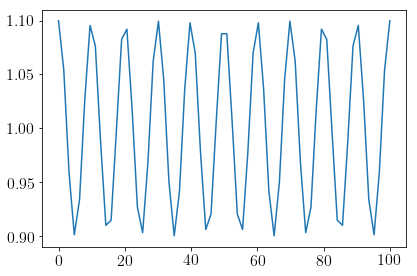

In [423]:
t = np.linspace(0, 100, 64)
plt.plot(t, const_w_osc(t, 1, 10, 0.1))

1.0000372882850095

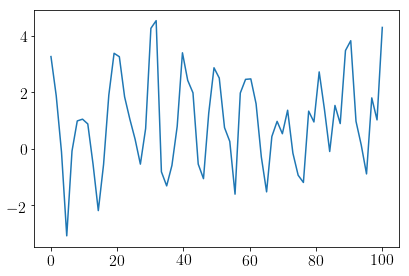

In [443]:
get_chi2(64, 1, const_w_osc, dict(a=1, period=10, amp=2), const, 2, 1, plot=True)

In [437]:
chi2s = [get_chi2(64, 1, const_w_osc, dict(a=1, period=10, amp=0.1), const, 2, 1) for _ in range(10000)]

Cutoff at 1.015604


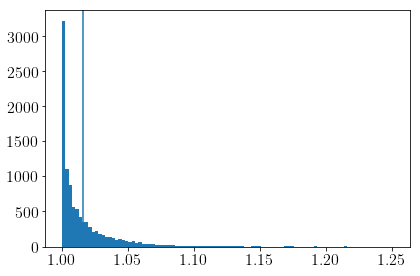

In [438]:
plt.hist(chi2s, bins=100)
cutoff = np.percentile(chi2s, 68)
plt.axvline(cutoff)
print('Cutoff at %f' % cutoff)
plt.show()

In [457]:
chi2s = [get_chi2(64, 1, const_w_osc, dict(a=1, period=10, amp=1.), const, 2, 1) for _ in range(10000)]

Cutoff at 1.010703


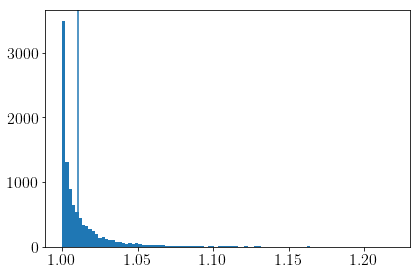

In [458]:
plt.hist(chi2s, bins=100)
cutoff = np.percentile(chi2s, 68)
plt.axvline(cutoff)
print('Cutoff at %f' % cutoff)
plt.show()

In [444]:
chi2s = [get_chi2(64, 1, const_w_osc, dict(a=1, period=10, amp=2), const, 2, 1) for _ in range(10000)]

Cutoff at 1.005576


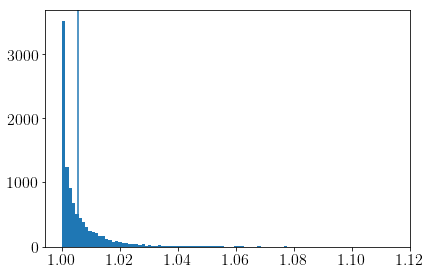

In [445]:
plt.hist(chi2s, bins=100)
cutoff = np.percentile(chi2s, 68)
plt.axvline(cutoff)
print('Cutoff at %f' % cutoff)
plt.show()

In [451]:
chi2s = [get_chi2(64, 1, const_w_osc, dict(a=1, period=10, amp=2), const, 2, 1, ret='truevalue') for _ in range(10000)]

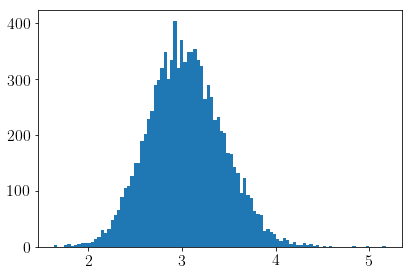

In [453]:
plt.hist(chi2s, bins=100)
plt.show()

## Data-driven spe error

In [61]:
df = read_pickles(data_dir, 'er_e_10_20_newer_spe')

Read 5103 datapoints from 25 files.


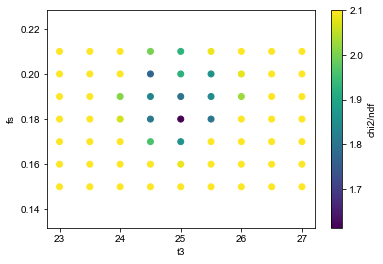

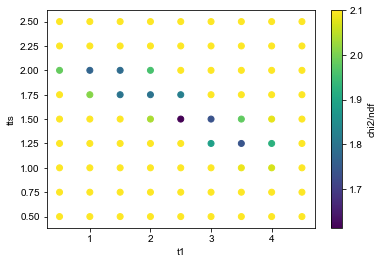

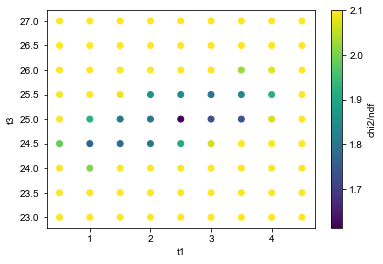

In [62]:
plot_all_slices(df, vmax=2.1)

In [63]:
minvalue(df)

{'chi2': 1.6126650051442681,
 'dset': 'er',
 'e_max': 20,
 'e_min': 10,
 'fs': 0.17999999999999999,
 'n_photons': 500000,
 'stored_stat': True,
 't1': 2.5,
 't3': 25.0,
 'tts': 1.5}

In [67]:
popt = minvalue(df, to_input=True)

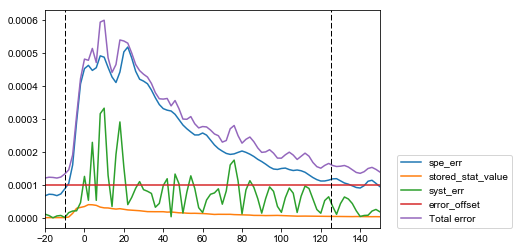

Chi2 in peak: (-10 to 30 ns): 1.93
Chi2 in tail: (30 to 125 ns): 1.48
Chi2 total: 1.61


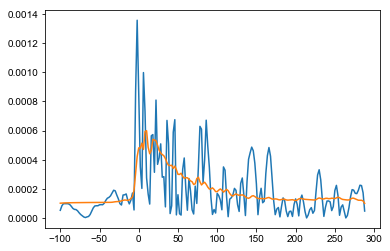

In [68]:
check_errors(**popt)

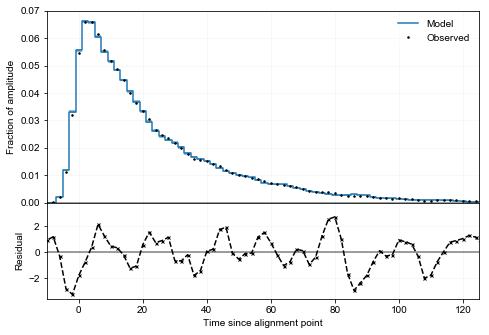

chi2 = 1.612665


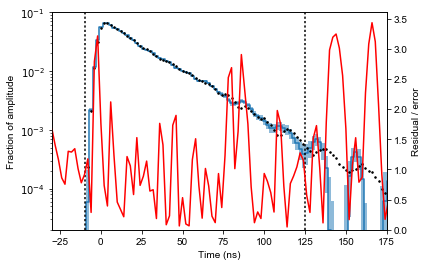

In [69]:
plot_model_manual(**popt)

In [80]:
mins = get_some_minima(df, 100, threshold=popt['chi2'] + 0.25)

Selected 15 values with chi2 ranging from 1.61 to 1.86...


In [81]:
print_minima(mins)

Giving the standard deviation for 15 points...
fs = 0.187 +- 0.009
t3 = 25.000 +- 0.365
t1 = 2.333 +- 0.745
tts = 1.650 +- 0.220
Giving the MAXIMUM deviation from BEST-FIT POINT (using chi2) for 15 points...
fs = 0.180 + 0.010 - 0.020
t3 = 25.000 + 0.500 - 0.500
t1 = 2.500 + 1.500 - 1.000
tts = 1.500 + 0.250 - 0.500


## Quad errors

In [124]:
p

{'chi2': 0.15445825612565142,
 'dset': 'er',
 'e_max': 20,
 'e_min': 10,
 'fs': 0.19,
 'n_photons': 500000,
 'stored_stat': True,
 't1': 1.5,
 't3': 24.5,
 'tts': 1.75}

In [125]:
model, sigma_syst, spe_err = s1_models_error(**p)

In [128]:
p['stored_stat_value'] = real_s1_wv_sigma(**p)

In [129]:
default_params['stored_stat_value'] = p['stored_stat_value']

In [130]:
# Build dicts
p = deepcopy(minvalue(df))
p1 = deepcopy(p)
p2 = deepcopy(p)

# Extract these parameters only once
# default_params['stored_stat_value'] = real_s1_wv_sigma(**p)
ydata, _ = real_s1_wv(**p)

# Now for p1...
p1['quad_adding'] = False
model, sigma_syst, spe_err = s1_models_error(**p1)
p1['ydata'], p1['model'], p1['syst_err'], p1['spe_err'] = (ydata, model, syst_err, spe_err)
p1['chi2'] = gof_manual(**p1)

# Now for p2...
p2['quad_adding'] = True
model, sigma_syst, spe_err = s1_models_error(**p2)
p2['ydata'], p2['model'], p2['syst_err'], p2['spe_err'] = (ydata, model, syst_err, spe_err)
p2['chi2'] = gof_manual(**p2)


gof=0.09465571363944048, fs=0.19, t1=1.5, t3=24.5, tts=1.75
gof=1.7652950812151533, fs=0.19, t1=1.5, t3=24.5, tts=1.75


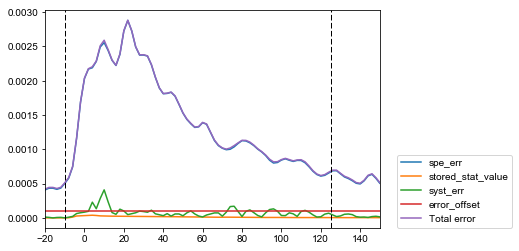

Chi2 in peak: (-10 to 30 ns): 0.13
Chi2 in tail: (30 to 125 ns): 0.08
Chi2 total: 0.09


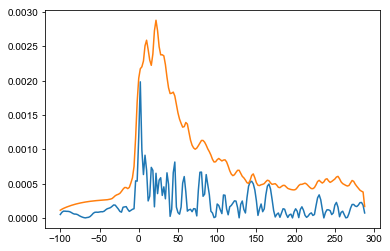

In [137]:
check_errors(**p1)

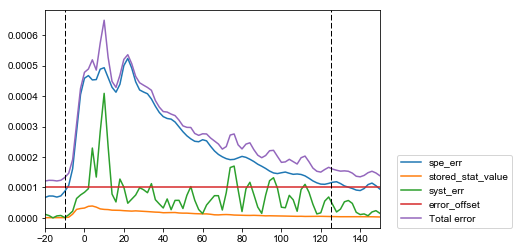

Chi2 in peak: (-10 to 30 ns): 1.90
Chi2 in tail: (30 to 125 ns): 1.71
Chi2 total: 1.77


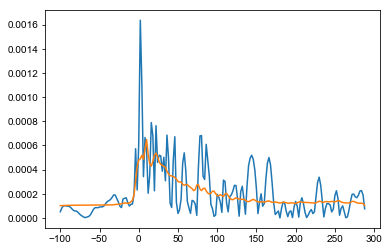

In [138]:
check_errors(**p2)

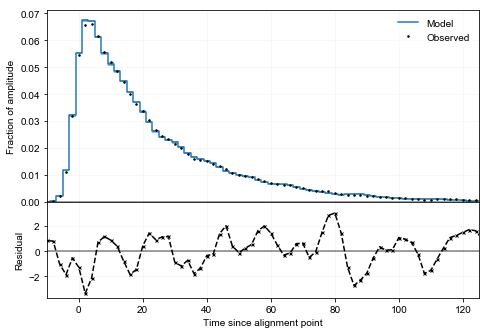

chi2 = 1.765295


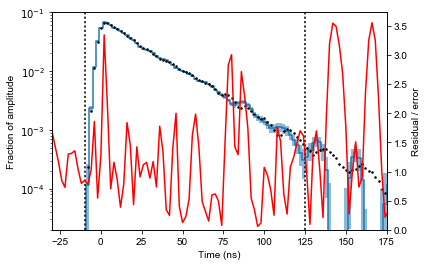

In [140]:
plot_model_manual(**p2)

In [ ]:
p1 = deepcopyy(p)

In [126]:
chi2 = gof_manual(ydata, model, syst_err, spe_err, **p)

array([  5.20008159e-05,   8.47355915e-05,   1.02297844e-04,
         1.01559138e-04,   9.87126241e-05,   9.81849245e-05,
         9.37794639e-05,   8.21374492e-05,   6.78890058e-05,
         6.17913444e-05,   6.12944478e-05,   5.41079202e-05,
         4.03611282e-05,   2.76511637e-05,   1.85283561e-05,
         9.43267479e-06,  -2.71787493e-07,  -3.95600837e-06,
        -3.84434292e-06,  -1.25557692e-05,  -3.69324599e-05,
        -6.39809951e-05,  -7.80271292e-05,  -7.77174749e-05,
        -7.68658021e-05,  -8.45702340e-05,  -8.96419877e-05,
        -8.99425294e-05,  -9.82332813e-05,  -1.14727921e-04,
        -1.29448630e-04,  -1.38047585e-04,  -1.47496811e-04,
        -1.65889237e-04,  -1.86150812e-04,  -1.85635908e-04,
        -1.57807243e-04,  -1.28605697e-04,  -1.26729894e-04,
        -1.58870012e-04,  -1.99186883e-04,  -2.19175853e-04,
        -2.14603853e-04,  -1.82281583e-04,  -1.42351299e-04,
        -1.25709451e-04,   9.84058905e-05,   2.29536223e-03,
         1.17664296e-02,

## Shift per s1

In [220]:
s1_waveforms, s1_waveforms_error, time_matrix, t_shift = simulate_s1_pulse(n_photons = int(1e6), max_shift = 10)

(-10, 20)

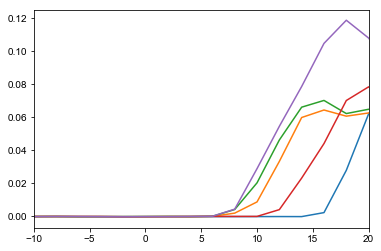

In [214]:
for i in range(5):
    plt.plot(spe_ts, s1_waveforms[:, i] / sum(s1_waveforms[:, i] ))
plt.xlim(-10, 20)

(-10, 20)

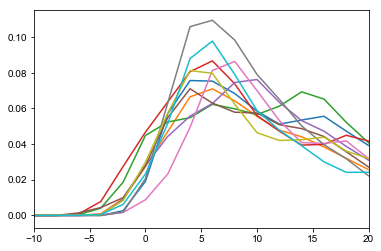

In [221]:
for i in range(10):
    plt.plot(spe_ts, s1_waveforms[:, i] / sum(s1_waveforms[:, i] ))
plt.xlim(-10, 20)

(-10, 20)

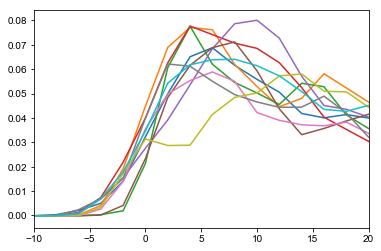

In [219]:
for i in range(10):
    plt.plot(spe_ts, s1_waveforms[:, i] / sum(s1_waveforms[:, i] ))
plt.xlim(-10, 20)

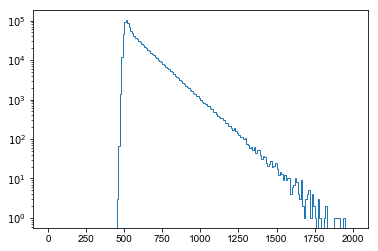

In [197]:
plt.hist(bla, range=(0, 2000), histtype='step', bins=200)
plt.yscale('log')
plt.show()

In [230]:
p = deepcopy(minvalue(df, to_input=False, keep_only_stored=True))

{'s1_model': 'two_exp', 'e_min': 10, 'tr': 15, 'neglect_statistical': False, 'max_shift': 10, 'dset': 'er', 'aft': 0.28, 'f_r': 0.0, 't3': 25.0, 'fs': 0.17999999999999999, 'tts': 1.5, 'e_max': 20, 'n_photons': 500000, 'error_offset': 0.0001, 't_max': 125.0, 't_min': -10.0, 't1': 2.5, 'quad_adding': True, 'stored_stat_value': array([  3.07804535e-08,   5.92180795e-08,   7.09834496e-08,
         5.14710958e-08,   3.01168574e-08,   4.08173680e-08,
         3.73462117e-08,   3.32615231e-08,   7.52955756e-08,
         1.15710767e-07,   1.19748888e-07,   1.34387793e-07,
         1.35912606e-07,   1.62253800e-07,   1.85788174e-07,
         1.86828163e-07,   2.14834888e-07,   1.93726183e-07,
         1.94519866e-07,   2.01598222e-07,   1.80019982e-07,
         1.71336610e-07,   1.78384911e-07,   1.94799460e-07,
         2.41142740e-07,   2.43048638e-07,   2.24170074e-07,
         1.95812491e-07,   2.10763441e-07,   2.28679693e-07,
         2.33560324e-07,   2.06717925e-07,   1.95629026e-07,
  

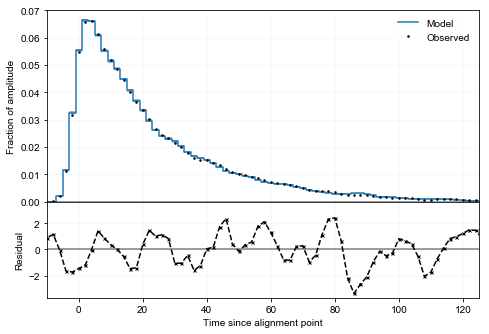

chi2 = 1.607674


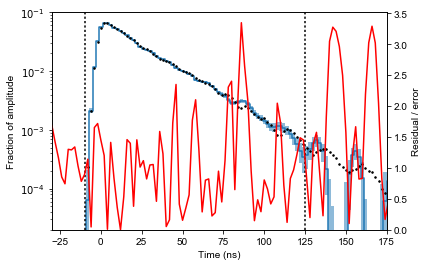

In [232]:
plot_model(**p)

## Sub-sample alignment

This has been implemented, done now.

## Statistics...

This part may be outdated after the error redefinition

In [73]:
gofs_list = []
nph_scan = [int(2e5), int(4e5), int(2e6)]
for nph in nph_scan:
    print(nph)
    popt['n_photons'] = nph
    gofs_list.append([gof(**popt) for _ in range(30)])

200000
Reading stat error from stored_stat parameter!
gof=4.847686336182956, fs=0.19, t1=2.0, t3=25.0, tts=1.75
Reading stat error from stored_stat parameter!
gof=5.893724830132279, fs=0.19, t1=2.0, t3=25.0, tts=1.75
Reading stat error from stored_stat parameter!
gof=5.6621421313708025, fs=0.19, t1=2.0, t3=25.0, tts=1.75
Reading stat error from stored_stat parameter!
gof=4.960056160807073, fs=0.19, t1=2.0, t3=25.0, tts=1.75
Reading stat error from stored_stat parameter!
gof=5.036084011427087, fs=0.19, t1=2.0, t3=25.0, tts=1.75
Reading stat error from stored_stat parameter!
gof=5.435783839662097, fs=0.19, t1=2.0, t3=25.0, tts=1.75
Reading stat error from stored_stat parameter!
gof=5.426565338782284, fs=0.19, t1=2.0, t3=25.0, tts=1.75
Reading stat error from stored_stat parameter!
gof=5.506808589426186, fs=0.19, t1=2.0, t3=25.0, tts=1.75
Reading stat error from stored_stat parameter!
gof=4.377088315327442, fs=0.19, t1=2.0, t3=25.0, tts=1.75
Reading stat error from stored_stat parameter!


In [88]:
nph_scan = [int(2e5), int(4e5), int(2e6), int(4e6)]

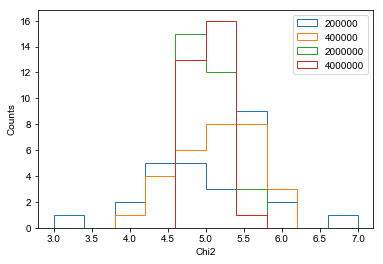

In [89]:
for gofs, l in zip(gofs_list, nph_scan):
    plt.hist(gofs, histtype = 'step', bins=10, range=(3,7), label='%d' % l)
plt.xlabel('Chi2')
plt.ylabel('Counts')
plt.legend()
plt.show()

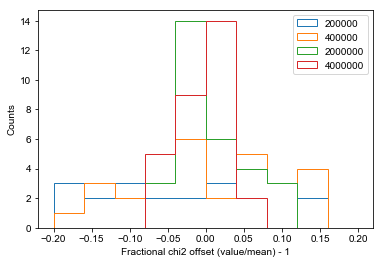

In [90]:
for gofs, l in zip(gofs_list, nph_scan):
    plt.hist(np.array(gofs) / np.mean(gofs) - 1, histtype = 'step', bins=10, range=(-.2,.2), label='%d' % l)
plt.xlabel('Fractional chi2 offset (value/mean) - 1')
plt.ylabel('Counts')
plt.legend()
plt.show()

In [91]:
np.std(gofs_list, axis=1) / np.mean(gofs_list, axis=1)

array([ 0.18106677,  0.10032424,  0.04895351,  0.0351447 ])

In [92]:
gofs_list_stat = []
nph_scan = [int(2e5), int(4e5), int(2e6)]
popt['neglect_systematic'] = False
for nph in nph_scan:
    print(nph)
    popt['n_photons'] = nph
    gofs_list_stat.append([gof(**popt) for _ in range(30)])

200000
Reading stat error from stored_stat parameter!
gof=2.994595859402191, fs=0.19, t1=2.0, t3=25.0, tts=1.75
Reading stat error from stored_stat parameter!
gof=1.7180867413599614, fs=0.19, t1=2.0, t3=25.0, tts=1.75
Reading stat error from stored_stat parameter!
gof=2.581299280602138, fs=0.19, t1=2.0, t3=25.0, tts=1.75
Reading stat error from stored_stat parameter!
gof=2.3044093119377864, fs=0.19, t1=2.0, t3=25.0, tts=1.75
Reading stat error from stored_stat parameter!
gof=3.87797057226319, fs=0.19, t1=2.0, t3=25.0, tts=1.75
Reading stat error from stored_stat parameter!
gof=2.3584730945375254, fs=0.19, t1=2.0, t3=25.0, tts=1.75
Reading stat error from stored_stat parameter!
gof=2.9466589522782445, fs=0.19, t1=2.0, t3=25.0, tts=1.75
Reading stat error from stored_stat parameter!
gof=2.2913916890875003, fs=0.19, t1=2.0, t3=25.0, tts=1.75
Reading stat error from stored_stat parameter!
gof=1.8378287717356594, fs=0.19, t1=2.0, t3=25.0, tts=1.75
Reading stat error from stored_stat paramet

In [94]:
np.std(gofs_list_stat, axis=1) / np.mean(gofs_list_stat, axis=1)

array([ 0.26617473,  0.19006954,  0.06307608])

#### The money plot

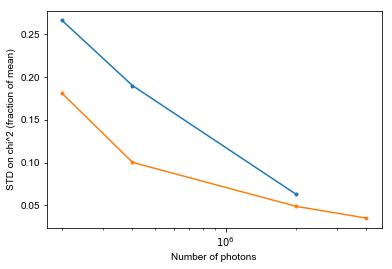

In [125]:
plt.plot(nph_scan, np.std(gofs_list_stat, axis=1) / np.mean(gofs_list_stat, axis=1), marker='.')
plt.plot(np.concatenate([nph_scan, [int(4e6)]]), np.std(gofs_list, axis=1) / np.mean(gofs_list, axis=1), marker='.')
plt.xscale('log')
plt.xlabel('Number of photons')
plt.ylabel('STD on chi^2 (fraction of mean)')

### Number of bootstrap trials

In [129]:
popt['n_photons'] = int(1e6)
popt['stored_stat'] = False

boot_scan = [20, 100, 200, 1000]
boots = []
for bt in boot_scan:
    print(bt)
    popt['bootstrap_trials'] = bt
    boots.append([gof(**popt) for _ in range(20)])


20
gof=1.934865562922848, fs=0.19, t1=2.0, t3=25.0, tts=1.75
gof=2.294249914987514, fs=0.19, t1=2.0, t3=25.0, tts=1.75
gof=1.897927975499547, fs=0.19, t1=2.0, t3=25.0, tts=1.75
gof=2.20651953781785, fs=0.19, t1=2.0, t3=25.0, tts=1.75
gof=2.3404212287590673, fs=0.19, t1=2.0, t3=25.0, tts=1.75
gof=2.824898948772344, fs=0.19, t1=2.0, t3=25.0, tts=1.75
gof=1.8283130743557883, fs=0.19, t1=2.0, t3=25.0, tts=1.75
gof=2.452338891592939, fs=0.19, t1=2.0, t3=25.0, tts=1.75
gof=2.0894702055698833, fs=0.19, t1=2.0, t3=25.0, tts=1.75
gof=2.5820449784985073, fs=0.19, t1=2.0, t3=25.0, tts=1.75
gof=1.9172095355070393, fs=0.19, t1=2.0, t3=25.0, tts=1.75
gof=1.789504337155653, fs=0.19, t1=2.0, t3=25.0, tts=1.75
gof=2.4301882420563343, fs=0.19, t1=2.0, t3=25.0, tts=1.75
gof=2.544293321063236, fs=0.19, t1=2.0, t3=25.0, tts=1.75
gof=2.240761883540313, fs=0.19, t1=2.0, t3=25.0, tts=1.75
gof=2.4581112505576193, fs=0.19, t1=2.0, t3=25.0, tts=1.75
gof=2.3309261638355525, fs=0.19, t1=2.0, t3=25.0, tts=1.75
gof=

KeyboardInterrupt: 

In [135]:
for bt in [400]:
    print(bt)
    popt['bootstrap_trials'] = bt
    boots.append([gof(**popt) for _ in range(20)])

400
gof=2.169790799650517, fs=0.19, t1=2.0, t3=25.0, tts=1.75
gof=2.0958783567618977, fs=0.19, t1=2.0, t3=25.0, tts=1.75
gof=2.0437041529418414, fs=0.19, t1=2.0, t3=25.0, tts=1.75
gof=2.189776783448054, fs=0.19, t1=2.0, t3=25.0, tts=1.75
gof=2.335455337573744, fs=0.19, t1=2.0, t3=25.0, tts=1.75
gof=2.016523940034678, fs=0.19, t1=2.0, t3=25.0, tts=1.75
gof=1.957150616151253, fs=0.19, t1=2.0, t3=25.0, tts=1.75
gof=2.2426380687513316, fs=0.19, t1=2.0, t3=25.0, tts=1.75
gof=2.0268897915146216, fs=0.19, t1=2.0, t3=25.0, tts=1.75
gof=1.7702937134946244, fs=0.19, t1=2.0, t3=25.0, tts=1.75
gof=2.2007160689622935, fs=0.19, t1=2.0, t3=25.0, tts=1.75
gof=1.8613155479428471, fs=0.19, t1=2.0, t3=25.0, tts=1.75
gof=2.138296685063111, fs=0.19, t1=2.0, t3=25.0, tts=1.75
gof=2.0494810091269486, fs=0.19, t1=2.0, t3=25.0, tts=1.75
gof=1.7838359820359413, fs=0.19, t1=2.0, t3=25.0, tts=1.75
gof=1.880781820935462, fs=0.19, t1=2.0, t3=25.0, tts=1.75
gof=2.299482036700427, fs=0.19, t1=2.0, t3=25.0, tts=1.75
g

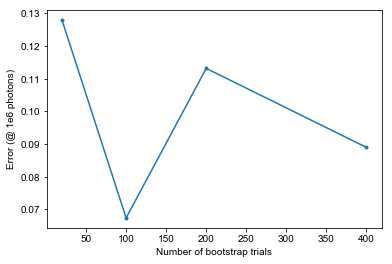

In [136]:
plt.plot([20, 100, 200, 400], np.std(boots, axis=1) / np.mean(boots, axis=1), marker='.')
plt.xlabel('Number of bootstrap trials')
plt.ylabel('Error (@ 1e6 photons)')

It looks like at 1M photons, the number of bootstrap trials is not so important as long as it is high enough (>= 100)